# Assignment 2 - Chen Yongquan [G2002341D]

In [ ]:
from __future__ import unicode_literals, print_function, division
# from html.parser import HTMLParser
from io import open
# from itertools import repeat
# from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
# import operator
import os
import random
import re
import string
import unicodedata

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

plt.switch_backend('agg')
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading Dataset

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
"""
class WMT14Parser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.sents = []
        self.author = False

    def handle_starttag(self, tag, attrs):
        if tag == 'author': self.author = True
        else: self.author = False

    def handle_data(self, data):
      if not self.author:
        self.sents.append(data.strip())

def parse_text_file(parser, file):
  parser.feed(open(file, encoding = 'utf-8').read())

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lang1_txtfiles = list(map(os.path.join, repeat('data\%s-%s\%s' % (lang1, lang2, lang1)), os.listdir('data\%s-%s\%s' % (lang1, lang2, lang1))))
    lang2_txtfiles = list(map(os.path.join, repeat('data\%s-%s\%s' % (lang1, lang2, lang2)), os.listdir('data\%s-%s\%s' % (lang1, lang2, lang2))))
    lang1_parser = WMT14Parser()
    lang2_parser = WMT14Parser()
    print("Reading %s..." % lang1)
    any(map(parse_text_file, repeat(lang1_parser), lang1_txtfiles))
    print("Reading %s..." % lang2)
    any(map(parse_text_file, repeat(lang2_parser), lang2_txtfiles))

    # Split every line into pairs and normalize
    print("Normalizing Strings...")
    pairs = [[normalizeString(l1), normalizeString(l2)] for l1, l2 in list(zip(lang1_parser.sents, lang2_parser.sents))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs
"""

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lang1_txt = open('data/news-commentary-v9.%s-%s.%s' % (lang1, lang2, lang1), "rb").read().decode(encoding="utf-8").strip().split('\n')
    lang2_txt = open('data/news-commentary-v9.%s-%s.%s' % (lang1, lang2, lang2), "rb").read().decode(encoding="utf-8").strip().split('\n')
    print('%s: %d' % (lang1, len(lang1_txt)))
    print('%s: %d' % (lang2, len(lang2_txt)))

    # Split every line into pairs and normalize
    pairs = [[normalizeString(l1), normalizeString(l2)] for l1, l2 in list(zip(lang1_txt, lang2_txt))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData5Fold(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    # collect test pairs
    num_test = int(len(pairs)*0.2)
    random.shuffle(pairs)

    input_langs = []
    output_langs = []
    train_pairs = []
    test_pairs = []
    for i in range(5):
      print("Processing set %d..." % (i + 1))
      if i == 0:
        train_pairs.append(pairs[num_test:])
        test_pairs.append(pairs[:num_test])
      elif i == 4:
        train_pairs.append(pairs[:i * num_test])
        test_pairs.append(pairs[i * num_test:])
      else:
        train_pairs.append(pairs[:i * num_test] + pairs[(i + 1) * num_test:])
        test_pairs.append(pairs[i * num_test:(i + 1) * num_test])
      input_langs.append(Lang(input_lang.name))
      output_langs.append(Lang(output_lang.name))
      for pair in train_pairs[i]:
        input_langs[i].addSentence(pair[0])
        output_langs[i].addSentence(pair[1])

    subsets = []
    for i in range(5):
      subsets.append({
        'input_lang': input_langs[i],
        'output_lang': output_langs[i],
        'train_pairs': train_pairs[i],
        'test_pairs': test_pairs[i]
      })
      print('')
      print('Subset %d:' % (i + 1))
      print("Number of train pairs:", len(subsets[i]['train_pairs']))
      print("Number of test pairs:", len(subsets[i]['test_pairs']))
      print("Counted words:")
      print(subsets[i]['input_lang'].name, subsets[i]['input_lang'].n_words)
      print(subsets[i]['output_lang'].name, subsets[i]['output_lang'].n_words)

    return subsets

In [ ]:
CS_subsets = prepareData5Fold('cs', 'en')

Reading lines...
cs: 146549
en: 146549
Read 146549 sentence pairs
Processing set 1...
Processing set 2...
Processing set 3...
Processing set 4...
Processing set 5...

Subset 1:
Number of train pairs: 117240
Number of test pairs: 29309
Counted words:
cs 116035
en 38810

Subset 2:
Number of train pairs: 117240
Number of test pairs: 29309
Counted words:
cs 116302
en 38881

Subset 3:
Number of train pairs: 117240
Number of test pairs: 29309
Counted words:
cs 114971
en 38518

Subset 4:
Number of train pairs: 117240
Number of test pairs: 29309
Counted words:
cs 115663
en 38722

Subset 5:
Number of train pairs: 117236
Number of test pairs: 29313
Counted words:
cs 115839
en 38837


In [ ]:
DE_subsets = prepareData5Fold('de', 'en')

Reading lines...
de: 201288
en: 201288
Read 201288 sentence pairs
Processing set 1...
Processing set 2...
Processing set 3...
Processing set 4...
Processing set 5...

Subset 1:
Number of train pairs: 161031
Number of test pairs: 40257
Counted words:
de 118573
en 44404

Subset 2:
Number of train pairs: 161031
Number of test pairs: 40257
Counted words:
de 119031
en 44580

Subset 3:
Number of train pairs: 161031
Number of test pairs: 40257
Counted words:
de 118591
en 44136

Subset 4:
Number of train pairs: 161031
Number of test pairs: 40257
Counted words:
de 117954
en 44359

Subset 5:
Number of train pairs: 161028
Number of test pairs: 40260
Counted words:
de 118517
en 44318


In [ ]:
FR_subsets = prepareData5Fold('fr', 'en')

Reading lines...
fr: 183251
en: 183251
Read 183251 sentence pairs
Processing set 1...
Processing set 2...
Processing set 3...
Processing set 4...
Processing set 5...

Subset 1:
Number of train pairs: 146601
Number of test pairs: 36650
Counted words:
fr 57494
en 42679

Subset 2:
Number of train pairs: 146601
Number of test pairs: 36650
Counted words:
fr 56616
en 42658

Subset 3:
Number of train pairs: 146601
Number of test pairs: 36650
Counted words:
fr 57254
en 42535

Subset 4:
Number of train pairs: 146601
Number of test pairs: 36650
Counted words:
fr 56984
en 42607

Subset 5:
Number of train pairs: 146600
Number of test pairs: 36651
Counted words:
fr 57195
en 42667


In [ ]:
RU_subsets = prepareData5Fold('ru', 'en')

Reading lines...
ru: 165602
en: 165602
Read 165602 sentence pairs
Processing set 1...
Processing set 2...
Processing set 3...
Processing set 4...
Processing set 5...

Subset 1:
Number of train pairs: 132482
Number of test pairs: 33120
Counted words:
ru 3840
en 41683

Subset 2:
Number of train pairs: 132482
Number of test pairs: 33120
Counted words:
ru 4000
en 41869

Subset 3:
Number of train pairs: 132482
Number of test pairs: 33120
Counted words:
ru 3966
en 41612

Subset 4:
Number of train pairs: 132482
Number of test pairs: 33120
Counted words:
ru 3960
en 41776

Subset 5:
Number of train pairs: 132480
Number of test pairs: 33122
Counted words:
ru 4272
en 41820


# The Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# The Decoder

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.embedding_size + self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.embedding_size + self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training
## Preparing Training Data

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, train_pairs, input_lang, output_lang, n_iters, max_length, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, max_length)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses

Plotting results
----------------

In [ ]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

In [ ]:
def evaluate(encoder, decoder, input_lang, output_lang, sentence, max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=1.0):
        reward = 0
        # Add here a function for shaping a reward

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward
    
    def __lt__(self, other):
        return self.eval() < other.eval()
    
    
from queue import PriorityQueue

def evaluate_beam_search(encoder, decoder, input_lang, output_lang, sentence, max_length, beam_size=2):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        # Number of sentence to generate
        endnodes = []
        number_required = 1
        
        # starting node -  hidden vector, previous node, word id, logp, length
        node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
        nodes = PriorityQueue()

        # start the queue
        nodes.put((-node.eval(), node))
        qsize = 1
        
        # start beam search
        while True:
            # give up when decoding takes too long
            if qsize > 2000: break

            # fetch the best node
            score, n = nodes.get()
            decoder_input = n.wordid
            decoder_hidden = n.h

            if n.wordid.item() == EOS_token and n.prevNode != None:
                endnodes.append((score, n))
                # if we reached maximum # of sentences required
                if len(endnodes) >= number_required:
                    break
                else:
                    continue
            #elif n.leng > max_length:
            #    continue

            # decode for one step using decoder
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # PUT HERE REAL BEAM SEARCH OF TOP
            log_prob, indexes = torch.topk(decoder_output, beam_size)
            nextnodes = []

            for new_k in range(beam_size):
                decoded_t = indexes[0][new_k].view(1, -1)
                log_p = log_prob[0][new_k].item()

                node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
                score = -node.eval()
                nextnodes.append((score, node))

            # put them into queue
            for i in range(len(nextnodes)):
                score, nn = nextnodes[i]
                nodes.put((score, nn))
                
            # increase qsize
            qsize += len(nextnodes) - 1
            
        # choose nbest paths, back trace them
        if len(endnodes) == 0:
            endnodes = [nodes.get() for _ in range(number_required)]

        _, n = endnodes[0]
        utterance = []
        utterance.append(output_lang.index2word[n.wordid.item()])
        
        # back trace
        while n.prevNode != None:
            n = n.prevNode
            utterance.append(output_lang.index2word[n.wordid.item()])

        utterance = utterance[::-1]
            
    return utterance, None

In [ ]:
def evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs, max_length, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, input_lang, output_lang, pair[0], max_length)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluateBleu(encoder, decoder, input_lang, output_lang, test_pairs, max_length, print_every=1000):
    start = time.time()
    n_iters = len(test_pairs)
    references, candidates, bleu = [], [], []
    for i, pair in enumerate(test_pairs):
        iter = i + 1
        sent_eng, sents_fre = pair
        sents_fre = [sents_fre.split(' ')]
        output_words, _ = evaluate(encoder, decoder, input_lang, output_lang, sent_eng, max_length)
        references.append(sents_fre)
        candidates.append(output_words[:-1]) # Remove <EOS> token
        if iter % print_every == 0:
            print('%s (%d %d%%)' % (timeSince(start, iter / n_iters),
                                    iter, iter / n_iters * 100))
    print('%s (%d %d%%)' % (timeSince(start, 1.0),
                            n_iters-1, 100))
    bleu.append(corpus_bleu(references, candidates, weights=(1, 0, 0, 0))) # BLEU-1
    bleu.append(corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))) # BLEU-2
    bleu.append(corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))) # BLEU-3
    bleu.append(corpus_bleu(references, candidates)) # BLEU-4
    return bleu

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluateBleu_beam_search(encoder, decoder, input_lang, output_lang, test_pairs, max_length, beam_size, print_every=1000):
    start = time.time()
    n_iters = len(test_pairs)
    references, candidates, bleu = [], [], []
    for i, pair in enumerate(test_pairs):
        iter = i + 1
        sent_eng, sents_fre = pair
        sents_fre = [sents_fre.split(' ')]
        output_words, _ = evaluate_beam_search(encoder,
                                               decoder,
                                               input_lang,
                                               output_lang,
                                               sent_eng,
                                               max_length,
                                               beam_size=beam_size)
        references.append(sents_fre)
        candidates.append(output_words[:-1]) # Remove <EOS> token
        if iter % print_every == 0:
            print('%s (%d %d%%)' % (timeSince(start, iter / n_iters),
                                    iter, iter / n_iters * 100))
    print('%s (%d %d%%)' % (timeSince(start, 1.0),
                            n_iters-1, 100))
    bleu.append(corpus_bleu(references, candidates, weights=(1, 0, 0, 0))) # BLEU-1
    bleu.append(corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))) # BLEU-2
    bleu.append(corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))) # BLEU-3
    bleu.append(corpus_bleu(references, candidates)) # BLEU-4
    return bleu

Training and Evaluating
=======================

## Czech

In [ ]:
CS_MAX_LENGTH = max([len(a.split(' ')) for a,b in CS_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in CS_subsets[0]['test_pairs']]) + 1
embedding_size = 512
hidden_size = 512

### Subset 1

2m 41s (- 131m 56s) (1000 2%) 7.3779
5m 15s (- 126m 2s) (2000 4%) 6.5220
7m 50s (- 122m 43s) (3000 6%) 6.3964
10m 48s (- 124m 14s) (4000 8%) 6.2420
14m 6s (- 127m 2s) (5000 10%) 6.0983
18m 6s (- 132m 45s) (6000 12%) 5.9692
21m 36s (- 132m 44s) (7000 14%) 5.9688
24m 53s (- 130m 42s) (8000 16%) 5.9038
27m 32s (- 125m 27s) (9000 18%) 5.8487
30m 6s (- 120m 26s) (10000 20%) 5.7850
32m 36s (- 115m 38s) (11000 22%) 5.7593
35m 10s (- 111m 23s) (12000 24%) 5.6580
37m 44s (- 107m 24s) (13000 26%) 5.6965
40m 15s (- 103m 32s) (14000 28%) 5.6868
42m 45s (- 99m 47s) (15000 30%) 5.5904
45m 19s (- 96m 18s) (16000 32%) 5.5629
47m 54s (- 92m 59s) (17000 34%) 5.5420
50m 27s (- 89m 41s) (18000 36%) 5.5656
52m 59s (- 86m 27s) (19000 38%) 5.5039
55m 30s (- 83m 15s) (20000 40%) 5.4776
58m 0s (- 80m 6s) (21000 42%) 5.4864
60m 30s (- 77m 0s) (22000 44%) 5.4708
63m 2s (- 73m 59s) (23000 46%) 5.4667
65m 33s (- 71m 0s) (24000 48%) 5.3960
68m 2s (- 68m 2s) (25000 50%) 5.3237
70m 34s (- 65m 9s) (26000 52%) 5.3363
7

<Figure size 432x288 with 0 Axes>

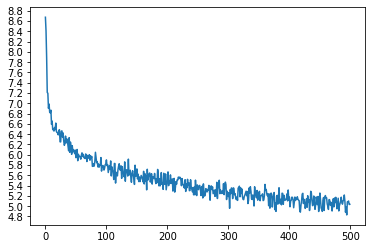

In [ ]:
CS_encoder1 = EncoderRNN(CS_subsets[0]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
CS_attn_decoder1 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  CS_subsets[0]['output_lang'].n_words,
                                  CS_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

CS_plot_losses_1 = trainIters(CS_encoder1,
                              CS_attn_decoder1,
                              CS_subsets[0]['train_pairs'],
                              CS_subsets[0]['input_lang'],
                              CS_subsets[0]['output_lang'],
                              50000,
                              CS_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': CS_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': CS_subsets[0]['input_lang'],
  'output_lang': CS_subsets[0]['output_lang'],
  'encoder': CS_encoder1.state_dict(),
  'attn_decoder': CS_attn_decoder1.state_dict()
}, 'model/CS_50000_S1.pth')

In [ ]:
checkpoint = torch.load('model/CS_50000_S1.pth')
CS_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
CS_subsets[0]['input_lang'] = checkpoint['input_lang']
CS_subsets[0]['output_lang'] = checkpoint['output_lang']
CS_encoder1 = EncoderRNN(CS_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
CS_attn_decoder1 = AttnDecoderRNN(hidden_size, embedding_size, CS_subsets[0]['output_lang'].n_words, CS_MAX_LENGTH, dropout_p=0.0).to(device)
CS_encoder1.load_state_dict(checkpoint['encoder'])
CS_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'], CS_MAX_LENGTH, n = 1)

In [ ]:
CS_BLEU_1 = evaluateBleu(CS_encoder1,
                         CS_attn_decoder1,
                         CS_subsets[0]['input_lang'],
                         CS_subsets[0]['output_lang'],
                         CS_subsets[0]['test_pairs'],
                         CS_MAX_LENGTH)
CS_BLEU_1

0m 44s (- 20m 48s) (1000 3%)
1m 26s (- 19m 36s) (2000 6%)
2m 7s (- 18m 41s) (3000 10%)
2m 52s (- 18m 13s) (4000 13%)
3m 37s (- 17m 37s) (5000 17%)
4m 20s (- 16m 50s) (6000 20%)
5m 0s (- 15m 58s) (7000 23%)
5m 46s (- 15m 22s) (8000 27%)
6m 27s (- 14m 35s) (9000 30%)
7m 11s (- 13m 52s) (10000 34%)
7m 52s (- 13m 7s) (11000 37%)
8m 39s (- 12m 28s) (12000 40%)
9m 21s (- 11m 44s) (13000 44%)
10m 4s (- 11m 0s) (14000 47%)
10m 46s (- 10m 16s) (15000 51%)
11m 28s (- 9m 33s) (16000 54%)
12m 10s (- 8m 48s) (17000 58%)
12m 51s (- 8m 4s) (18000 61%)
13m 33s (- 7m 21s) (19000 64%)
14m 15s (- 6m 37s) (20000 68%)
14m 56s (- 5m 54s) (21000 71%)
15m 38s (- 5m 11s) (22000 75%)
16m 20s (- 4m 28s) (23000 78%)
17m 2s (- 3m 46s) (24000 81%)
17m 43s (- 3m 3s) (25000 85%)
18m 23s (- 2m 20s) (26000 88%)
19m 5s (- 1m 37s) (27000 92%)
19m 45s (- 0m 55s) (28000 95%)
20m 25s (- 0m 13s) (29000 98%)


[0.2147115247027209,
 0.0755633594224067,
 0.030599520727180342,
 0.012110277201434665]

In [ ]:
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'], CS_MAX_LENGTH, 4)
CS_BEAM_1

2m 23s (- 67m 30s) (1000 3%)
4m 38s (- 63m 19s) (2000 6%)
6m 44s (- 59m 6s) (3000 10%)
8m 59s (- 56m 56s) (4000 13%)
11m 17s (- 54m 54s) (5000 17%)
13m 23s (- 52m 1s) (6000 20%)
15m 23s (- 49m 2s) (7000 23%)
17m 36s (- 46m 53s) (8000 27%)
19m 46s (- 44m 37s) (9000 30%)
22m 10s (- 42m 48s) (10000 34%)
24m 22s (- 40m 34s) (11000 37%)
26m 29s (- 38m 12s) (12000 40%)
28m 41s (- 36m 0s) (13000 44%)
30m 53s (- 33m 47s) (14000 47%)
33m 23s (- 31m 50s) (15000 51%)
35m 53s (- 29m 51s) (16000 54%)
37m 55s (- 27m 27s) (17000 58%)
39m 59s (- 25m 7s) (18000 61%)
42m 10s (- 22m 53s) (19000 64%)
44m 18s (- 20m 37s) (20000 68%)
46m 24s (- 18m 21s) (21000 71%)
48m 43s (- 16m 11s) (22000 75%)
50m 54s (- 13m 57s) (23000 78%)
53m 14s (- 11m 46s) (24000 81%)
55m 32s (- 9m 34s) (25000 85%)
57m 43s (- 7m 20s) (26000 88%)
60m 4s (- 5m 8s) (27000 92%)
62m 31s (- 2m 55s) (28000 95%)
64m 37s (- 0m 41s) (29000 98%)


[0.22857016171249905,
 0.08197727251830367,
 0.034893190714194694,
 0.014763999411416621]

---
### Beam width experiments

In [ ]:
start = time.time()
CS_BLEU_1 = evaluateBleu(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH)
display(timeSince(start, 100))
display(CS_BLEU_1)

'0m 4s (- -1m 55s)'

[0.1715686274509804,
 0.05465390204678719,
 0.021614566427796918,
 0.009154652154246722]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 1)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 4s (- -1m 55s)'

[0.16454423592493297,
 0.05233163785441777,
 0.020682919226867453,
 0.008748414613498437]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 2)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 8s (- -1m 51s)'

[0.20043763676148793,
 0.07167338727390397,
 0.03201049016688136,
 0.014533711908038548]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 3)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 9s (- -1m 50s)'

[0.209016393442623,
 0.07472889306279525,
 0.03338162639836089,
 0.01517579081543289]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 4)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 11s (- -1m 48s)'

[0.22190611664295878,
 0.07864818085891731,
 0.03404654955175795,
 0.01408354730016048]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 5)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 13s (- -1m 46s)'

[0.2193149381541389,
 0.07762174736229045,
 0.03274720614999101,
 0.013687696787197508]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 6)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 12s (- -1m 47s)'

[0.21708015267175573,
 0.07734124083269134,
 0.03270311565092175,
 0.013685126369298304]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 7)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 13s (- -1m 46s)'

[0.21928982725527832,
 0.07796860313044641,
 0.03182103626117622,
 0.013427025100297725]

In [ ]:
start = time.time()
CS_BEAM_1 = evaluateBleu_beam_search(CS_encoder1, CS_attn_decoder1, CS_subsets[0]['input_lang'], CS_subsets[0]['output_lang'], CS_subsets[0]['test_pairs'][0:100], CS_MAX_LENGTH, 8)
display(timeSince(start, 100))
display(CS_BEAM_1)

'0m 13s (- -1m 46s)'

[0.2193110140708394,
 0.07842829422459853,
 0.03207441637014565,
 0.01355178533777936]

---

### Subset 2

2m 36s (- 127m 43s) (1000 2%) 7.2309
5m 9s (- 123m 46s) (2000 4%) 6.5444
7m 36s (- 119m 18s) (3000 6%) 6.3783
10m 7s (- 116m 21s) (4000 8%) 6.2096
12m 37s (- 113m 40s) (5000 10%) 6.1036
15m 8s (- 111m 4s) (6000 12%) 6.0281
17m 42s (- 108m 46s) (7000 14%) 5.9651
20m 13s (- 106m 10s) (8000 16%) 5.8999
22m 44s (- 103m 37s) (9000 18%) 5.8337
25m 13s (- 100m 52s) (10000 20%) 5.8075
27m 49s (- 98m 37s) (11000 22%) 5.8282
30m 24s (- 96m 17s) (12000 24%) 5.7787
32m 54s (- 93m 38s) (13000 26%) 5.6746
35m 25s (- 91m 4s) (14000 28%) 5.6778
37m 55s (- 88m 29s) (15000 30%) 5.6512
40m 24s (- 85m 52s) (16000 32%) 5.6122
42m 53s (- 83m 16s) (17000 34%) 5.5626
45m 23s (- 80m 42s) (18000 36%) 5.6019
47m 58s (- 78m 16s) (19000 38%) 5.5680
50m 29s (- 75m 43s) (20000 40%) 5.5529
53m 1s (- 73m 13s) (21000 42%) 5.5233
55m 29s (- 70m 37s) (22000 44%) 5.4672
57m 58s (- 68m 2s) (23000 46%) 5.4061
60m 27s (- 65m 29s) (24000 48%) 5.4265
62m 54s (- 62m 54s) (25000 50%) 5.4301
65m 26s (- 60m 24s) (26000 52%) 5.4153

<Figure size 432x288 with 0 Axes>

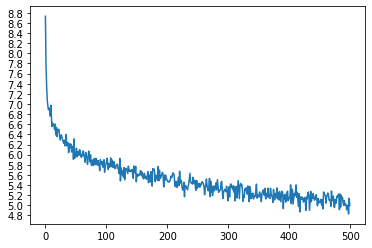

In [ ]:
CS_encoder2 = EncoderRNN(CS_subsets[1]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
CS_attn_decoder2 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  CS_subsets[1]['output_lang'].n_words,
                                  CS_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

CS_plot_losses_2 = trainIters(CS_encoder2,
                              CS_attn_decoder2,
                              CS_subsets[1]['train_pairs'],
                              CS_subsets[1]['input_lang'],
                              CS_subsets[1]['output_lang'],
                              50000,
                              CS_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': CS_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': CS_subsets[1]['input_lang'],
  'output_lang': CS_subsets[1]['output_lang'],
  'encoder': CS_encoder2.state_dict(),
  'attn_decoder': CS_attn_decoder2.state_dict()
}, 'model/CS_50000_S2.pth')

In [ ]:
checkpoint = torch.load('model/CS_50000_S2.pth')
CS_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
CS_subsets[1]['input_lang'] = checkpoint['input_lang']
CS_subsets[1]['output_lang'] = checkpoint['output_lang']
CS_encoder2 = EncoderRNN(CS_subsets[1]['input_lang'].n_words, hidden_size, embedding_size).to(device)
CS_attn_decoder2 = AttnDecoderRNN(hidden_size, embedding_size, CS_subsets[1]['output_lang'].n_words, CS_MAX_LENGTH, dropout_p=0.0).to(device)
CS_encoder2.load_state_dict(checkpoint['encoder'])
CS_attn_decoder2.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(CS_encoder2, CS_attn_decoder2, CS_subsets[1]['input_lang'], CS_subsets[1]['output_lang'], CS_subsets[1]['train_pairs'], CS_MAX_LENGTH, n = 1)

In [ ]:
CS_BLEU_2 = evaluateBleu(CS_encoder2, CS_attn_decoder2, CS_subsets[1]['input_lang'], CS_subsets[1]['output_lang'], CS_subsets[1]['test_pairs'], CS_MAX_LENGTH)
CS_BLEU_2

0m 33s (- 15m 47s) (1000 3%)
1m 4s (- 14m 38s) (2000 6%)
1m 36s (- 14m 3s) (3000 10%)
2m 6s (- 13m 22s) (4000 13%)
2m 38s (- 12m 50s) (5000 17%)
3m 8s (- 12m 11s) (6000 20%)
3m 38s (- 11m 35s) (7000 23%)
4m 9s (- 11m 4s) (8000 27%)
4m 38s (- 10m 27s) (9000 30%)
5m 6s (- 9m 52s) (10000 34%)
5m 38s (- 9m 23s) (11000 37%)
6m 12s (- 8m 56s) (12000 40%)
6m 44s (- 8m 27s) (13000 44%)
7m 15s (- 7m 56s) (14000 47%)
7m 47s (- 7m 25s) (15000 51%)
8m 18s (- 6m 54s) (16000 54%)
8m 47s (- 6m 22s) (17000 58%)
9m 19s (- 5m 51s) (18000 61%)
9m 51s (- 5m 21s) (19000 64%)
10m 22s (- 4m 49s) (20000 68%)
10m 54s (- 4m 18s) (21000 71%)
11m 24s (- 3m 47s) (22000 75%)
11m 56s (- 3m 16s) (23000 78%)
12m 30s (- 2m 46s) (24000 81%)
13m 2s (- 2m 14s) (25000 85%)
13m 36s (- 1m 43s) (26000 88%)
14m 9s (- 1m 12s) (27000 92%)
14m 41s (- 0m 41s) (28000 95%)
15m 13s (- 0m 9s) (29000 98%)


[0.22669315475702378,
 0.08177490470251768,
 0.03412746239046386,
 0.013986833336026926]

### Subset 3

2m 37s (- 128m 52s) (1000 2%) 7.1447
5m 8s (- 123m 31s) (2000 4%) 6.5814
7m 41s (- 120m 32s) (3000 6%) 6.3592
10m 15s (- 117m 52s) (4000 8%) 6.2389
12m 47s (- 115m 5s) (5000 10%) 6.0779
15m 19s (- 112m 22s) (6000 12%) 6.0451
17m 51s (- 109m 42s) (7000 14%) 5.9684
20m 26s (- 107m 19s) (8000 16%) 5.9296
22m 59s (- 104m 44s) (9000 18%) 5.8671
25m 28s (- 101m 53s) (10000 20%) 5.8166
27m 57s (- 99m 5s) (11000 22%) 5.6969
30m 26s (- 96m 23s) (12000 24%) 5.7142
32m 59s (- 93m 54s) (13000 26%) 5.6965
35m 31s (- 91m 21s) (14000 28%) 5.6766
38m 1s (- 88m 43s) (15000 30%) 5.5912
40m 32s (- 86m 10s) (16000 32%) 5.6180
43m 1s (- 83m 32s) (17000 34%) 5.5840
45m 28s (- 80m 51s) (18000 36%) 5.5393
47m 59s (- 78m 17s) (19000 38%) 5.4911
50m 32s (- 75m 48s) (20000 40%) 5.4735
53m 2s (- 73m 14s) (21000 42%) 5.4830
55m 34s (- 70m 44s) (22000 44%) 5.3992
58m 4s (- 68m 11s) (23000 46%) 5.3618
60m 37s (- 65m 40s) (24000 48%) 5.4292
63m 9s (- 63m 9s) (25000 50%) 5.3984
65m 39s (- 60m 36s) (26000 52%) 5.3281
6

<Figure size 432x288 with 0 Axes>

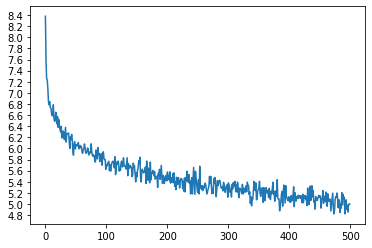

In [ ]:
CS_encoder3 = EncoderRNN(CS_subsets[2]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
CS_attn_decoder3 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  CS_subsets[2]['output_lang'].n_words,
                                  CS_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

CS_plot_losses_3 = trainIters(CS_encoder3,
                              CS_attn_decoder3,
                              CS_subsets[2]['train_pairs'],
                              CS_subsets[2]['input_lang'],
                              CS_subsets[2]['output_lang'],
                              50000,
                              CS_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': CS_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': CS_subsets[2]['input_lang'],
  'output_lang': CS_subsets[2]['output_lang'],
  'encoder': CS_encoder3.state_dict(),
  'attn_decoder': CS_attn_decoder3.state_dict()
}, 'model/CS_50000_S3.pth')

In [ ]:
checkpoint = torch.load('model/CS_50000_S3.pth')
CS_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
CS_subsets[2]['input_lang'] = checkpoint['input_lang']
CS_subsets[2]['output_lang'] = checkpoint['output_lang']
CS_encoder3 = EncoderRNN(CS_subsets[2]['input_lang'].n_words, hidden_size, embedding_size).to(device)
CS_attn_decoder3 = AttnDecoderRNN(hidden_size, embedding_size, CS_subsets[2]['output_lang'].n_words, CS_MAX_LENGTH, dropout_p=0.0).to(device)
CS_encoder3.load_state_dict(checkpoint['encoder'])
CS_attn_decoder3.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(CS_encoder3, CS_attn_decoder3, CS_subsets[2]['input_lang'], CS_subsets[2]['output_lang'], CS_subsets[2]['train_pairs'], CS_MAX_LENGTH, n = 1)

In [ ]:
CS_BLEU_3 = evaluateBleu(CS_encoder3, CS_attn_decoder3, CS_subsets[2]['input_lang'], CS_subsets[2]['output_lang'], CS_subsets[2]['test_pairs'], CS_MAX_LENGTH)
CS_BLEU_3

0m 39s (- 18m 28s) (1000 3%)
1m 17s (- 17m 44s) (2000 6%)
1m 59s (- 17m 28s) (3000 10%)
2m 36s (- 16m 31s) (4000 13%)
3m 29s (- 16m 56s) (5000 17%)
4m 17s (- 16m 40s) (6000 20%)
5m 1s (- 16m 2s) (7000 23%)
5m 38s (- 15m 0s) (8000 27%)
6m 16s (- 14m 10s) (9000 30%)
6m 52s (- 13m 17s) (10000 34%)
7m 30s (- 12m 30s) (11000 37%)
8m 9s (- 11m 45s) (12000 40%)
8m 46s (- 11m 0s) (13000 44%)
9m 27s (- 10m 20s) (14000 47%)
10m 5s (- 9m 37s) (15000 51%)
10m 43s (- 8m 55s) (16000 54%)
11m 22s (- 8m 14s) (17000 58%)
12m 0s (- 7m 32s) (18000 61%)
12m 37s (- 6m 50s) (19000 64%)
13m 16s (- 6m 10s) (20000 68%)
13m 51s (- 5m 29s) (21000 71%)
14m 28s (- 4m 48s) (22000 75%)
15m 7s (- 4m 9s) (23000 78%)
15m 51s (- 3m 30s) (24000 81%)
16m 29s (- 2m 50s) (25000 85%)
17m 8s (- 2m 10s) (26000 88%)
17m 45s (- 1m 31s) (27000 92%)
18m 20s (- 0m 51s) (28000 95%)
19m 1s (- 0m 12s) (29000 98%)
19m 13s (- 0m 0s) (29308 100%)


[0.22146324146829324,
 0.0770442289069845,
 0.03103798769932007,
 0.012266994548712884]

### Subset 4

2m 40s (- 131m 24s) (1000 2%) 7.1747
5m 12s (- 124m 55s) (2000 4%) 6.5735
7m 42s (- 120m 45s) (3000 6%) 6.3943
10m 16s (- 118m 11s) (4000 8%) 6.2639
12m 46s (- 114m 57s) (5000 10%) 6.1446
15m 20s (- 112m 29s) (6000 12%) 6.0762
17m 46s (- 109m 12s) (7000 14%) 5.9212
20m 16s (- 106m 25s) (8000 16%) 5.8756
22m 47s (- 103m 50s) (9000 18%) 5.8236
25m 16s (- 101m 5s) (10000 20%) 5.7736
27m 49s (- 98m 37s) (11000 22%) 5.7846
30m 21s (- 96m 8s) (12000 24%) 5.7237
32m 56s (- 93m 44s) (13000 26%) 5.6902
35m 27s (- 91m 11s) (14000 28%) 5.6031
37m 53s (- 88m 25s) (15000 30%) 5.6308
40m 24s (- 85m 52s) (16000 32%) 5.5967
42m 55s (- 83m 19s) (17000 34%) 5.5126
45m 24s (- 80m 43s) (18000 36%) 5.5377
47m 56s (- 78m 12s) (19000 38%) 5.5546
50m 26s (- 75m 39s) (20000 40%) 5.5073
52m 56s (- 73m 7s) (21000 42%) 5.4720
55m 29s (- 70m 36s) (22000 44%) 5.4687
58m 1s (- 68m 7s) (23000 46%) 5.4453
60m 32s (- 65m 35s) (24000 48%) 5.4015
63m 5s (- 63m 5s) (25000 50%) 5.4057
65m 38s (- 60m 35s) (26000 52%) 5.3480

<Figure size 432x288 with 0 Axes>

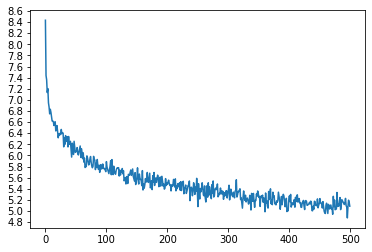

In [ ]:
CS_encoder4 = EncoderRNN(CS_subsets[3]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
CS_attn_decoder4 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  CS_subsets[3]['output_lang'].n_words,
                                  CS_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

CS_plot_losses_4 = trainIters(CS_encoder4,
                              CS_attn_decoder4,
                              CS_subsets[3]['train_pairs'],
                              CS_subsets[3]['input_lang'],
                              CS_subsets[3]['output_lang'],
                              50000,
                              CS_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': CS_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': CS_subsets[3]['input_lang'],
  'output_lang': CS_subsets[3]['output_lang'],
  'encoder': CS_encoder4.state_dict(),
  'attn_decoder': CS_attn_decoder4.state_dict()
}, 'model/CS_50000_S4.pth')

In [ ]:
checkpoint = torch.load('model/CS_50000_S4.pth')
CS_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
CS_subsets[3]['input_lang'] = checkpoint['input_lang']
CS_subsets[3]['output_lang'] = checkpoint['output_lang']
CS_encoder4 = EncoderRNN(CS_subsets[3]['input_lang'].n_words, hidden_size, embedding_size).to(device)
CS_attn_decoder4 = AttnDecoderRNN(hidden_size, embedding_size, CS_subsets[3]['output_lang'].n_words, CS_MAX_LENGTH, dropout_p=0.0).to(device)
CS_encoder4.load_state_dict(checkpoint['encoder'])
CS_attn_decoder4.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(CS_encoder4, CS_attn_decoder4, CS_subsets[3]['input_lang'], CS_subsets[3]['output_lang'], CS_subsets[3]['train_pairs'], CS_MAX_LENGTH, n = 1)

In [ ]:
CS_BLEU_4 = evaluateBleu(CS_encoder4, CS_attn_decoder4, CS_subsets[3]['input_lang'], CS_subsets[3]['output_lang'], CS_subsets[3]['test_pairs'], CS_MAX_LENGTH)
CS_BLEU_4

0m 42s (- 19m 54s) (1000 3%)
1m 25s (- 19m 27s) (2000 6%)
2m 7s (- 18m 37s) (3000 10%)
2m 47s (- 17m 42s) (4000 13%)
3m 30s (- 17m 4s) (5000 17%)
4m 14s (- 16m 28s) (6000 20%)
4m 58s (- 15m 52s) (7000 23%)
5m 42s (- 15m 13s) (8000 27%)
6m 24s (- 14m 26s) (9000 30%)
7m 5s (- 13m 41s) (10000 34%)
7m 46s (- 12m 55s) (11000 37%)
8m 29s (- 12m 14s) (12000 40%)
9m 11s (- 11m 31s) (13000 44%)
9m 53s (- 10m 49s) (14000 47%)
10m 35s (- 10m 6s) (15000 51%)
11m 20s (- 9m 25s) (16000 54%)
12m 2s (- 8m 43s) (17000 58%)
12m 45s (- 8m 0s) (18000 61%)
13m 27s (- 7m 18s) (19000 64%)
14m 11s (- 6m 36s) (20000 68%)
14m 54s (- 5m 53s) (21000 71%)
15m 36s (- 5m 11s) (22000 75%)
16m 20s (- 4m 28s) (23000 78%)
17m 3s (- 3m 46s) (24000 81%)
17m 47s (- 3m 3s) (25000 85%)
18m 28s (- 2m 20s) (26000 88%)
19m 12s (- 1m 38s) (27000 92%)
19m 54s (- 0m 55s) (28000 95%)
20m 35s (- 0m 13s) (29000 98%)
20m 47s (- 0m 0s) (29307 100%)


[0.2060117791810445,
 0.06828818405099693,
 0.02613544770718876,
 0.009772681140780589]

### Subset 5

2m 35s (- 127m 8s) (1000 2%) 7.1463
5m 9s (- 123m 42s) (2000 4%) 6.5746
7m 44s (- 121m 9s) (3000 6%) 6.4079
10m 11s (- 117m 9s) (4000 8%) 6.2455
12m 43s (- 114m 29s) (5000 10%) 6.1547
15m 12s (- 111m 29s) (6000 12%) 5.9980
17m 41s (- 108m 40s) (7000 14%) 5.9282
20m 9s (- 105m 49s) (8000 16%) 5.8897
22m 40s (- 103m 16s) (9000 18%) 5.8179
25m 12s (- 100m 50s) (10000 20%) 5.7524
27m 46s (- 98m 27s) (11000 22%) 5.7945
30m 20s (- 96m 6s) (12000 24%) 5.7655
32m 50s (- 93m 29s) (13000 26%) 5.6805
35m 24s (- 91m 4s) (14000 28%) 5.6490
37m 56s (- 88m 32s) (15000 30%) 5.6441
40m 27s (- 85m 57s) (16000 32%) 5.6215
42m 54s (- 83m 18s) (17000 34%) 5.5766
45m 28s (- 80m 51s) (18000 36%) 5.5315
48m 2s (- 78m 23s) (19000 38%) 5.5412
50m 33s (- 75m 49s) (20000 40%) 5.4580
53m 5s (- 73m 18s) (21000 42%) 5.5223
55m 37s (- 70m 47s) (22000 44%) 5.4468
58m 10s (- 68m 17s) (23000 46%) 5.4126
60m 42s (- 65m 45s) (24000 48%) 5.4316
63m 11s (- 63m 11s) (25000 50%) 5.3696
65m 39s (- 60m 36s) (26000 52%) 5.3485
6

<Figure size 432x288 with 0 Axes>

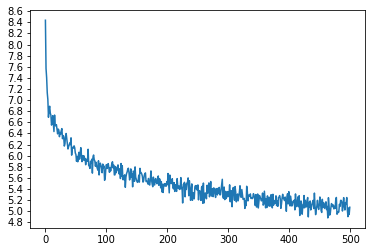

In [ ]:
CS_encoder5 = EncoderRNN(CS_subsets[4]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
CS_attn_decoder5 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  CS_subsets[4]['output_lang'].n_words,
                                  CS_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

CS_plot_losses_5 = trainIters(CS_encoder5,
                              CS_attn_decoder5,
                              CS_subsets[4]['train_pairs'],
                              CS_subsets[4]['input_lang'],
                              CS_subsets[4]['output_lang'],
                              50000,
                              CS_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': CS_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': CS_subsets[4]['input_lang'],
  'output_lang': CS_subsets[4]['output_lang'],
  'encoder': CS_encoder5.state_dict(),
  'attn_decoder': CS_attn_decoder5.state_dict()
}, 'model/CS_50000_S5.pth')

In [ ]:
checkpoint = torch.load('model/CS_50000_S5.pth')
CS_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
CS_subsets[4]['input_lang'] = checkpoint['input_lang']
CS_subsets[4]['output_lang'] = checkpoint['output_lang']
CS_encoder5 = EncoderRNN(CS_subsets[4]['input_lang'].n_words, hidden_size, embedding_size).to(device)
CS_attn_decoder5 = AttnDecoderRNN(hidden_size, embedding_size, CS_subsets[4]['output_lang'].n_words, CS_MAX_LENGTH, dropout_p=0.0).to(device)
CS_encoder5.load_state_dict(checkpoint['encoder'])
CS_attn_decoder5.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(CS_encoder5, CS_attn_decoder5, CS_subsets[4]['input_lang'], CS_subsets[4]['output_lang'], CS_subsets[4]['train_pairs'], CS_MAX_LENGTH, n = 1)

In [ ]:
CS_BLEU_5 = evaluateBleu(CS_encoder5, CS_attn_decoder5, CS_subsets[4]['input_lang'], CS_subsets[4]['output_lang'], CS_subsets[4]['test_pairs'], CS_MAX_LENGTH)
CS_BLEU_5

0m 42s (- 20m 13s) (1000 3%)
1m 25s (- 19m 26s) (2000 6%)
2m 11s (- 19m 10s) (3000 10%)
2m 56s (- 18m 37s) (4000 13%)
3m 41s (- 17m 57s) (5000 17%)
4m 23s (- 17m 5s) (6000 20%)
5m 7s (- 16m 19s) (7000 23%)
5m 49s (- 15m 29s) (8000 27%)
6m 31s (- 14m 42s) (9000 30%)
7m 14s (- 13m 59s) (10000 34%)
7m 55s (- 13m 12s) (11000 37%)
8m 36s (- 12m 25s) (12000 40%)
9m 19s (- 11m 42s) (13000 44%)
10m 6s (- 11m 3s) (14000 47%)
10m 47s (- 10m 17s) (15000 51%)
11m 29s (- 9m 33s) (16000 54%)
12m 9s (- 8m 48s) (17000 57%)
12m 52s (- 8m 5s) (18000 61%)
13m 36s (- 7m 23s) (19000 64%)
14m 18s (- 6m 39s) (20000 68%)
15m 4s (- 5m 57s) (21000 71%)
15m 50s (- 5m 15s) (22000 75%)
16m 35s (- 4m 33s) (23000 78%)
17m 18s (- 3m 49s) (24000 81%)
18m 1s (- 3m 6s) (25000 85%)
18m 42s (- 2m 23s) (26000 88%)
19m 23s (- 1m 39s) (27000 92%)
20m 6s (- 0m 56s) (28000 95%)
20m 48s (- 0m 13s) (29000 98%)
21m 3s (- 0m 0s) (29312 100%)


[0.20557046505244558,
 0.07260542852069556,
 0.02897469813239368,
 0.011591370204903771]

### Average BLEU

In [ ]:
np.average(np.stack((CS_BLEU_1, CS_BLEU_2, CS_BLEU_3, CS_BLEU_4, CS_BLEU_5)), 0)

array([0.21489003, 0.07505522, 0.03017502, 0.01194563])

## German

In [ ]:
DE_MAX_LENGTH = max([len(a.split(' ')) for a,b in DE_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in DE_subsets[0]['test_pairs']]) + 1
embedding_size = 256
hidden_size = 256

### Subset 1

1m 46s (- 15m 55s) (1000 10%) 6.1594
3m 29s (- 13m 58s) (2000 20%) 5.7426
5m 8s (- 12m 0s) (3000 30%) 5.6186
6m 48s (- 10m 12s) (4000 40%) 5.5685
8m 22s (- 8m 22s) (5000 50%) 5.4177
10m 1s (- 6m 40s) (6000 60%) 5.5443
11m 39s (- 4m 59s) (7000 70%) 5.3444
13m 15s (- 3m 18s) (8000 80%) 5.3269
14m 53s (- 1m 39s) (9000 90%) 5.4378
16m 33s (- 0m 0s) (10000 100%) 5.4483


<Figure size 432x288 with 0 Axes>

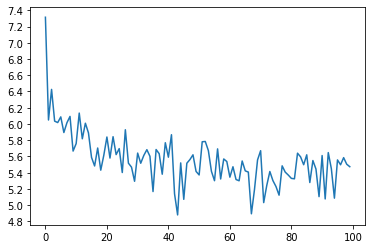

In [ ]:
DE_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
DE_attn_decoder1 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  DE_subsets[0]['output_lang'].n_words,
                                  DE_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

DE_plot_losses_1 = trainIters(DE_encoder1,
                              DE_attn_decoder1,
                              DE_subsets[0]['train_pairs'],
                              DE_subsets[0]['input_lang'],
                              DE_subsets[0]['output_lang'],
                              10000,
                              DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[0]['input_lang'],
  'output_lang': DE_subsets[0]['output_lang'],
  'encoder': DE_encoder1.state_dict(),
  'attn_decoder': DE_attn_decoder1.state_dict()
}, 'model/DE_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/DE_10000_S1.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[0]['input_lang'] = checkpoint['input_lang']
DE_subsets[0]['output_lang'] = checkpoint['output_lang']
DE_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
DE_attn_decoder1 = AttnDecoderRNN(hidden_size, embedding_size, DE_subsets[0]['output_lang'].n_words, DE_MAX_LENGTH, dropout_p=0.0).to(device)
DE_encoder1.load_state_dict(checkpoint['encoder'])
DE_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(DE_encoder1, DE_attn_decoder1, DE_subsets[0]['input_lang'], DE_subsets[0]['output_lang'], DE_subsets[0]['test_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
DE_BLEU_1 = evaluateBleu(DE_encoder1,
                         DE_attn_decoder1,
                         DE_subsets[0]['input_lang'],
                         DE_subsets[0]['output_lang'],
                         DE_subsets[0]['test_pairs'],
                         DE_MAX_LENGTH)
DE_BLEU_1

0m 24s (- 15m 50s) (1000 2%)
0m 49s (- 15m 39s) (2000 4%)
1m 14s (- 15m 20s) (3000 7%)
1m 38s (- 14m 51s) (4000 9%)
2m 3s (- 14m 33s) (5000 12%)
2m 28s (- 14m 8s) (6000 14%)
2m 54s (- 13m 49s) (7000 17%)
3m 17s (- 13m 17s) (8000 19%)
3m 38s (- 12m 37s) (9000 22%)
4m 0s (- 12m 8s) (10000 24%)
4m 23s (- 11m 39s) (11000 27%)
4m 45s (- 11m 12s) (12000 29%)
5m 9s (- 10m 49s) (13000 32%)
5m 34s (- 10m 27s) (14000 34%)
6m 0s (- 10m 6s) (15000 37%)
6m 23s (- 9m 41s) (16000 39%)
6m 49s (- 9m 20s) (17000 42%)
7m 14s (- 8m 57s) (18000 44%)
7m 39s (- 8m 34s) (19000 47%)
8m 3s (- 8m 9s) (20000 49%)
8m 27s (- 7m 45s) (21000 52%)
8m 55s (- 7m 24s) (22000 54%)
9m 26s (- 7m 5s) (23000 57%)
9m 51s (- 6m 40s) (24000 59%)
10m 16s (- 6m 16s) (25000 62%)
10m 39s (- 5m 50s) (26000 64%)
11m 6s (- 5m 27s) (27000 67%)
11m 31s (- 5m 2s) (28000 69%)
11m 54s (- 4m 37s) (29000 72%)
12m 12s (- 4m 10s) (30000 74%)
12m 35s (- 3m 45s) (31000 77%)
13m 0s (- 3m 21s) (32000 79%)
13m 23s (- 2m 56s) (33000 81%)
13m 46s (- 2

[0.09472371760932133,
 0.025355243469559714,
 0.0033330591297752407,
 0.0004953494176581338]

In [ ]:
DE_BEAM_1 = evaluateBleu_beam_search(DE_encoder1, DE_attn_decoder1, DE_subsets[0]['input_lang'], DE_subsets[0]['output_lang'], DE_subsets[0]['test_pairs'], DE_MAX_LENGTH, 4)
DE_BEAM_1

0m 50s (- 33m 2s) (1000 2%)
1m 39s (- 31m 44s) (2000 4%)
2m 31s (- 31m 16s) (3000 7%)
3m 21s (- 30m 29s) (4000 9%)
4m 14s (- 29m 51s) (5000 12%)
5m 5s (- 29m 6s) (6000 14%)
5m 57s (- 28m 16s) (7000 17%)
6m 48s (- 27m 25s) (8000 19%)
7m 34s (- 26m 19s) (9000 22%)
8m 25s (- 25m 28s) (10000 24%)
9m 13s (- 24m 32s) (11000 27%)
10m 3s (- 23m 40s) (12000 29%)
10m 54s (- 22m 52s) (13000 32%)
11m 48s (- 22m 8s) (14000 34%)
12m 42s (- 21m 24s) (15000 37%)
13m 36s (- 20m 37s) (16000 39%)
14m 29s (- 19m 49s) (17000 42%)
15m 22s (- 19m 0s) (18000 44%)
16m 13s (- 18m 9s) (19000 47%)
17m 6s (- 17m 19s) (20000 49%)
17m 57s (- 16m 27s) (21000 52%)
18m 49s (- 15m 37s) (22000 54%)
19m 41s (- 14m 46s) (23000 57%)
20m 29s (- 13m 52s) (24000 59%)
21m 20s (- 13m 1s) (25000 62%)
22m 9s (- 12m 9s) (26000 64%)
23m 1s (- 11m 18s) (27000 67%)
23m 56s (- 10m 28s) (28000 69%)
24m 48s (- 9m 37s) (29000 72%)
25m 26s (- 8m 41s) (30000 74%)
26m 18s (- 7m 51s) (31000 77%)
27m 9s (- 7m 0s) (32000 79%)
28m 0s (- 6m 9s) (

[0.10901366208560218,
 0.027716168298934165,
 0.005392659914264452,
 0.0008663936397701171]

### Subset 2

1m 40s (- 15m 2s) (1000 10%) 6.2531
3m 17s (- 13m 8s) (2000 20%) 5.6230
4m 52s (- 11m 22s) (3000 30%) 5.3826
6m 27s (- 9m 41s) (4000 40%) 5.4164
8m 1s (- 8m 1s) (5000 50%) 5.4148
9m 37s (- 6m 24s) (6000 60%) 5.4657
11m 15s (- 4m 49s) (7000 70%) 5.3064
12m 53s (- 3m 13s) (8000 80%) 5.3825
14m 29s (- 1m 36s) (9000 90%) 5.3657
16m 10s (- 0m 0s) (10000 100%) 5.5334


<Figure size 432x288 with 0 Axes>

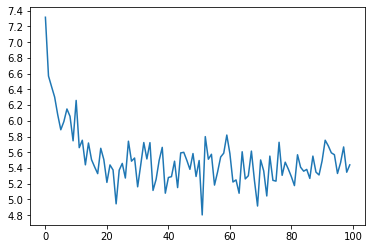

In [ ]:
DE_encoder2 = EncoderRNN(DE_subsets[1]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
DE_attn_decoder2 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  DE_subsets[1]['output_lang'].n_words,
                                  DE_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

DE_plot_losses_2 = trainIters(DE_encoder2,
                              DE_attn_decoder2,
                              DE_subsets[1]['train_pairs'],
                              DE_subsets[1]['input_lang'],
                              DE_subsets[1]['output_lang'],
                              10000,
                              DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[1]['input_lang'],
  'output_lang': DE_subsets[1]['output_lang'],
  'encoder': DE_encoder2.state_dict(),
  'attn_decoder': DE_attn_decoder2.state_dict()
}, 'model/DE_10000_S2.pth')

In [ ]:
checkpoint = torch.load('model/DE_10000_S2.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[1]['input_lang'] = checkpoint['input_lang']
DE_subsets[1]['output_lang'] = checkpoint['output_lang']
DE_encoder2 = EncoderRNN(DE_subsets[1]['input_lang'].n_words, hidden_size, embedding_size).to(device)
DE_attn_decoder2 = AttnDecoderRNN(hidden_size, embedding_size, DE_subsets[1]['output_lang'].n_words, DE_MAX_LENGTH, dropout_p=0.0).to(device)
DE_encoder2.load_state_dict(checkpoint['encoder'])
DE_attn_decoder2.load_state_dict(checkpoint['attn_decoder'])

In [ ]:
evaluateRandomly(DE_encoder2, DE_attn_decoder2, DE_subsets[1]['input_lang'], DE_subsets[1]['output_lang'], DE_subsets[1]['train_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
DE_BLEU_2 = evaluateBleu(DE_encoder2, DE_attn_decoder2, DE_subsets[1]['input_lang'], DE_subsets[1]['output_lang'], DE_subsets[1]['test_pairs'], DE_MAX_LENGTH)
DE_BLEU_2

0m 50s (- 33m 3s) (1000 2%)
1m 37s (- 31m 3s) (2000 4%)
2m 24s (- 29m 53s) (3000 7%)
3m 12s (- 29m 1s) (4000 9%)
4m 1s (- 28m 21s) (5000 12%)
4m 52s (- 27m 49s) (6000 14%)
5m 42s (- 27m 5s) (7000 17%)
6m 30s (- 26m 13s) (8000 19%)
7m 20s (- 25m 28s) (9000 22%)
8m 9s (- 24m 40s) (10000 24%)
8m 57s (- 23m 50s) (11000 27%)
9m 44s (- 22m 55s) (12000 29%)
10m 33s (- 22m 8s) (13000 32%)
11m 24s (- 21m 23s) (14000 34%)
12m 14s (- 20m 37s) (15000 37%)
13m 3s (- 19m 47s) (16000 39%)
13m 53s (- 18m 59s) (17000 42%)
14m 40s (- 18m 9s) (18000 44%)
15m 27s (- 17m 17s) (19000 47%)
16m 16s (- 16m 29s) (20000 49%)
17m 3s (- 15m 38s) (21000 52%)
17m 52s (- 14m 49s) (22000 54%)
18m 41s (- 14m 1s) (23000 57%)
19m 26s (- 13m 10s) (24000 59%)
20m 13s (- 12m 20s) (25000 62%)
21m 1s (- 11m 31s) (26000 64%)
21m 48s (- 10m 42s) (27000 67%)
22m 37s (- 9m 54s) (28000 69%)
23m 27s (- 9m 6s) (29000 72%)
24m 15s (- 8m 17s) (30000 74%)
25m 4s (- 7m 29s) (31000 77%)
25m 53s (- 6m 40s) (32000 79%)
26m 44s (- 5m 52s) (

[0.15310388014453405,
 0.04201180186506658,
 0.006916446138660083,
 0.0016221798444191315]

### Subset 3

1m 38s (- 14m 43s) (1000 10%) 6.0926
3m 15s (- 13m 2s) (2000 20%) 5.7692
4m 53s (- 11m 25s) (3000 30%) 5.5392
6m 29s (- 9m 44s) (4000 40%) 5.4245
8m 4s (- 8m 4s) (5000 50%) 5.4022
9m 41s (- 6m 27s) (6000 60%) 5.4277
11m 16s (- 4m 49s) (7000 70%) 5.3590
12m 54s (- 3m 13s) (8000 80%) 5.3571
14m 33s (- 1m 37s) (9000 90%) 5.4052
16m 14s (- 0m 0s) (10000 100%) 5.5345


<Figure size 432x288 with 0 Axes>

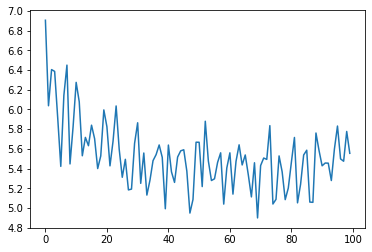

In [ ]:
DE_encoder3 = EncoderRNN(DE_subsets[2]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
DE_attn_decoder3 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  DE_subsets[2]['output_lang'].n_words,
                                  DE_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

DE_plot_losses_3 = trainIters(DE_encoder3,
                              DE_attn_decoder3,
                              DE_subsets[2]['train_pairs'],
                              DE_subsets[2]['input_lang'],
                              DE_subsets[2]['output_lang'],
                              10000,
                              DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[2]['input_lang'],
  'output_lang': DE_subsets[2]['output_lang'],
  'encoder': DE_encoder3.state_dict(),
  'attn_decoder': DE_attn_decoder3.state_dict()
}, 'model/DE_10000_S3.pth')

In [ ]:
checkpoint = torch.load('model/DE_10000_S3.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[2]['input_lang'] = checkpoint['input_lang']
DE_subsets[2]['output_lang'] = checkpoint['output_lang']
DE_encoder3 = EncoderRNN(DE_subsets[2]['input_lang'].n_words, hidden_size, embedding_size).to(device)
DE_attn_decoder3 = AttnDecoderRNN(hidden_size, embedding_size, DE_subsets[2]['output_lang'].n_words, DE_MAX_LENGTH, dropout_p=0.0).to(device)
DE_encoder3.load_state_dict(checkpoint['encoder'])
DE_attn_decoder3.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(DE_encoder3, DE_attn_decoder3, DE_subsets[2]['input_lang'], DE_subsets[2]['output_lang'], DE_subsets[2]['train_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
DE_BLEU_3 = evaluateBleu(DE_encoder3, DE_attn_decoder3, DE_subsets[2]['input_lang'], DE_subsets[2]['output_lang'], DE_subsets[2]['test_pairs'], DE_MAX_LENGTH)
DE_BLEU_3

0m 44s (- 29m 21s) (1000 2%)
1m 29s (- 28m 37s) (2000 4%)
2m 14s (- 27m 51s) (3000 7%)
2m 57s (- 26m 51s) (4000 9%)
3m 41s (- 25m 58s) (5000 12%)
4m 25s (- 25m 14s) (6000 14%)
5m 7s (- 24m 19s) (7000 17%)
5m 49s (- 23m 28s) (8000 19%)
6m 32s (- 22m 41s) (9000 22%)
7m 14s (- 21m 54s) (10000 24%)
7m 56s (- 21m 7s) (11000 27%)
8m 38s (- 20m 20s) (12000 29%)
9m 21s (- 19m 36s) (13000 32%)
10m 2s (- 18m 49s) (14000 34%)
10m 45s (- 18m 6s) (15000 37%)
11m 27s (- 17m 22s) (16000 39%)
12m 9s (- 16m 38s) (17000 42%)
12m 52s (- 15m 55s) (18000 44%)
13m 34s (- 15m 11s) (19000 47%)
14m 16s (- 14m 27s) (20000 49%)
14m 59s (- 13m 45s) (21000 52%)
15m 43s (- 13m 3s) (22000 54%)
16m 24s (- 12m 18s) (23000 57%)
17m 6s (- 11m 35s) (24000 59%)
17m 50s (- 10m 53s) (25000 62%)
18m 32s (- 10m 10s) (26000 64%)
19m 14s (- 9m 27s) (27000 67%)
19m 57s (- 8m 44s) (28000 69%)
20m 39s (- 8m 1s) (29000 72%)
21m 20s (- 7m 17s) (30000 74%)
22m 3s (- 6m 35s) (31000 77%)
22m 46s (- 5m 52s) (32000 79%)
23m 29s (- 5m 9s)

[0.14314955332851872,
 0.03546754036232768,
 0.003931445337896471,
 0.0005828292367973833]

### Subset 4

1m 38s (- 14m 43s) (1000 10%) 6.0404
3m 14s (- 12m 59s) (2000 20%) 5.6196
4m 49s (- 11m 15s) (3000 30%) 5.4715
6m 25s (- 9m 38s) (4000 40%) 5.4530
7m 58s (- 7m 58s) (5000 50%) 5.2902
9m 35s (- 6m 23s) (6000 60%) 5.3888
11m 10s (- 4m 47s) (7000 70%) 5.3684
12m 44s (- 3m 11s) (8000 80%) 5.1593
14m 23s (- 1m 35s) (9000 90%) 5.3169
16m 2s (- 0m 0s) (10000 100%) 5.3260


<Figure size 432x288 with 0 Axes>

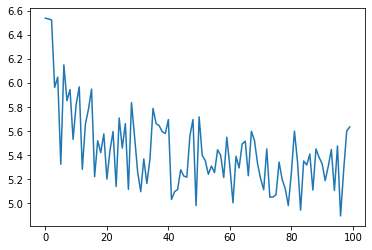

In [ ]:
DE_encoder4 = EncoderRNN(DE_subsets[3]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
DE_attn_decoder4 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  DE_subsets[3]['output_lang'].n_words,
                                  DE_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

DE_plot_losses_4 = trainIters(DE_encoder4,
                              DE_attn_decoder4,
                              DE_subsets[3]['train_pairs'],
                              DE_subsets[3]['input_lang'],
                              DE_subsets[3]['output_lang'],
                              10000,
                              DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[3]['input_lang'],
  'output_lang': DE_subsets[3]['output_lang'],
  'encoder': DE_encoder4.state_dict(),
  'attn_decoder': DE_attn_decoder4.state_dict()
}, 'model/DE_10000_S4.pth')

In [ ]:
checkpoint = torch.load('model/DE_10000_S4.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[3]['input_lang'] = checkpoint['input_lang']
DE_subsets[3]['output_lang'] = checkpoint['output_lang']
DE_encoder4 = EncoderRNN(DE_subsets[3]['input_lang'].n_words, hidden_size, embedding_size).to(device)
DE_attn_decoder4 = AttnDecoderRNN(hidden_size, embedding_size, DE_subsets[3]['output_lang'].n_words, DE_MAX_LENGTH, dropout_p=0.0).to(device)
DE_encoder4.load_state_dict(checkpoint['encoder'])
DE_attn_decoder4.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(DE_encoder4, DE_attn_decoder4, DE_subsets[3]['input_lang'], DE_subsets[3]['output_lang'], DE_subsets[3]['train_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
DE_BLEU_4 = evaluateBleu(DE_encoder4, DE_attn_decoder4, DE_subsets[3]['input_lang'], DE_subsets[3]['output_lang'], DE_subsets[3]['test_pairs'], DE_MAX_LENGTH)
DE_BLEU_4

0m 24s (- 16m 10s) (1000 2%)
0m 49s (- 15m 43s) (2000 4%)
1m 14s (- 15m 27s) (3000 7%)
1m 39s (- 15m 5s) (4000 9%)
2m 5s (- 14m 46s) (5000 12%)
2m 31s (- 14m 25s) (6000 14%)
2m 56s (- 13m 59s) (7000 17%)
3m 21s (- 13m 33s) (8000 19%)
3m 47s (- 13m 10s) (9000 22%)
4m 14s (- 12m 49s) (10000 24%)
4m 41s (- 12m 27s) (11000 27%)
5m 6s (- 12m 0s) (12000 29%)
5m 31s (- 11m 35s) (13000 32%)
5m 56s (- 11m 9s) (14000 34%)
6m 22s (- 10m 44s) (15000 37%)
6m 48s (- 10m 18s) (16000 39%)
7m 13s (- 9m 53s) (17000 42%)
7m 38s (- 9m 27s) (18000 44%)
8m 3s (- 9m 1s) (19000 47%)
8m 28s (- 8m 34s) (20000 49%)
8m 53s (- 8m 9s) (21000 52%)
9m 18s (- 7m 43s) (22000 54%)
9m 44s (- 7m 18s) (23000 57%)
10m 9s (- 6m 52s) (24000 59%)
10m 34s (- 6m 27s) (25000 62%)
10m 59s (- 6m 1s) (26000 64%)
11m 24s (- 5m 36s) (27000 67%)
11m 50s (- 5m 10s) (28000 69%)
12m 15s (- 4m 45s) (29000 72%)
12m 41s (- 4m 20s) (30000 74%)
13m 7s (- 3m 55s) (31000 77%)
13m 33s (- 3m 29s) (32000 79%)
13m 58s (- 3m 4s) (33000 81%)
14m 23s (

[0.13768846929874307,
 0.03420736601438249,
 0.005283206587266871,
 0.0008039298783845438]

### Subset 5

1m 35s (- 14m 18s) (1000 10%) 6.2170
3m 11s (- 12m 45s) (2000 20%) 5.7978
4m 48s (- 11m 12s) (3000 30%) 5.5077
6m 28s (- 9m 43s) (4000 40%) 5.5698
8m 7s (- 8m 7s) (5000 50%) 5.4828
9m 45s (- 6m 30s) (6000 60%) 5.3897
11m 22s (- 4m 52s) (7000 70%) 5.4629
13m 3s (- 3m 15s) (8000 80%) 5.5365
14m 42s (- 1m 38s) (9000 90%) 5.3866
16m 24s (- 0m 0s) (10000 100%) 5.6050


<Figure size 432x288 with 0 Axes>

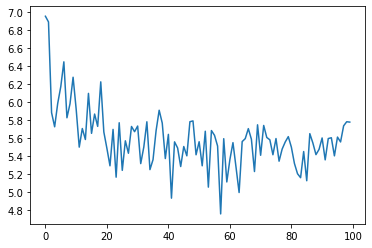

In [ ]:
DE_encoder5 = EncoderRNN(DE_subsets[4]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
DE_attn_decoder5 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  DE_subsets[4]['output_lang'].n_words,
                                  DE_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

DE_plot_losses_5 = trainIters(DE_encoder5,
                              DE_attn_decoder5,
                              DE_subsets[4]['train_pairs'],
                              DE_subsets[4]['input_lang'],
                              DE_subsets[4]['output_lang'],
                              10000,
                              DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[4]['input_lang'],
  'output_lang': DE_subsets[4]['output_lang'],
  'encoder': DE_encoder5.state_dict(),
  'attn_decoder': DE_attn_decoder5.state_dict()
}, 'model/DE_10000_S5.pth')

In [ ]:
checkpoint = torch.load('model/DE_10000_S5.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[4]['input_lang'] = checkpoint['input_lang']
DE_subsets[4]['output_lang'] = checkpoint['output_lang']
DE_encoder5 = EncoderRNN(DE_subsets[4]['input_lang'].n_words, hidden_size, embedding_size).to(device)
DE_attn_decoder5 = AttnDecoderRNN(hidden_size, embedding_size, DE_subsets[4]['output_lang'].n_words, DE_MAX_LENGTH, dropout_p=0.0).to(device)
DE_encoder5.load_state_dict(checkpoint['encoder'])
DE_attn_decoder5.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(DE_encoder5, DE_attn_decoder5, DE_subsets[4]['input_lang'], DE_subsets[4]['output_lang'], DE_subsets[4]['train_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
DE_BLEU_5 = evaluateBleu(DE_encoder5, DE_attn_decoder5, DE_subsets[4]['input_lang'], DE_subsets[4]['output_lang'], DE_subsets[4]['test_pairs'], DE_MAX_LENGTH)
DE_BLEU_5

0m 33s (- 21m 50s) (1000 2%)
1m 7s (- 21m 36s) (2000 4%)
1m 44s (- 21m 35s) (3000 7%)
2m 19s (- 21m 8s) (4000 9%)
2m 56s (- 20m 43s) (5000 12%)
3m 32s (- 20m 11s) (6000 14%)
4m 8s (- 19m 42s) (7000 17%)
4m 43s (- 19m 2s) (8000 19%)
5m 18s (- 18m 25s) (9000 22%)
5m 53s (- 17m 51s) (10000 24%)
6m 31s (- 17m 21s) (11000 27%)
7m 7s (- 16m 47s) (12000 29%)
7m 45s (- 16m 15s) (13000 32%)
8m 20s (- 15m 38s) (14000 34%)
8m 55s (- 15m 2s) (15000 37%)
9m 29s (- 14m 23s) (16000 39%)
10m 5s (- 13m 48s) (17000 42%)
10m 42s (- 13m 14s) (18000 44%)
11m 17s (- 12m 38s) (19000 47%)
11m 52s (- 12m 2s) (20000 49%)
12m 29s (- 11m 27s) (21000 52%)
13m 3s (- 10m 50s) (22000 54%)
13m 39s (- 10m 14s) (23000 57%)
14m 17s (- 9m 40s) (24000 59%)
14m 53s (- 9m 5s) (25000 62%)
15m 28s (- 8m 29s) (26000 64%)
16m 6s (- 7m 54s) (27000 67%)
16m 43s (- 7m 19s) (28000 69%)
17m 19s (- 6m 43s) (29000 72%)
17m 55s (- 6m 7s) (30000 74%)
18m 30s (- 5m 31s) (31000 76%)
19m 5s (- 4m 55s) (32000 79%)
19m 40s (- 4m 19s) (33000 8

[0.10920895503535998,
 0.019320680835826557,
 0.002420022173663529,
 0.00034856661179768697]

### Average BLEU

In [ ]:
np.average(np.stack((DE_BLEU_1, DE_BLEU_2, DE_BLEU_3, DE_BLEU_4, DE_BLEU_5)), 0)

array([0.12757492, 0.03127253, 0.00437684, 0.00077057])

## French

Here we experiment with reducing embedding size to reduce training time.  
We follow Google's recommendation here: https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html
```Python
embedding_dimensions =  number_of_categories**0.25
```
For the French dataset there are 57000 French words and 42000 English words on average across the 5 subsets, which evaluates to 15 and 14 respectively, thus we use 15 as our embedding size for both encoders and decoders.

In [ ]:
FR_MAX_LENGTH = max([len(a.split(' ')) for a,b in FR_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in FR_subsets[0]['test_pairs']]) + 1
embedding_size = 15
hidden_size = 256

### Subset 1

1m 26s (- 12m 56s) (1000 10%) 5.9794
2m 52s (- 11m 28s) (2000 20%) 5.8908
4m 19s (- 10m 5s) (3000 30%) 5.8826
5m 48s (- 8m 42s) (4000 40%) 6.0255
7m 21s (- 7m 21s) (5000 50%) 6.1048
8m 54s (- 5m 56s) (6000 60%) 6.0603
10m 25s (- 4m 28s) (7000 70%) 6.0491
12m 0s (- 3m 0s) (8000 80%) 6.1205
13m 37s (- 1m 30s) (9000 90%) 6.0625
15m 10s (- 0m 0s) (10000 100%) 6.0746


<Figure size 432x288 with 0 Axes>

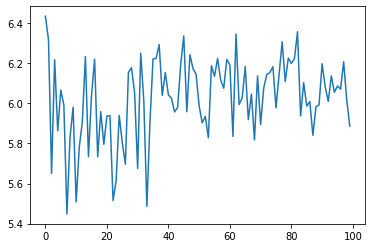

In [ ]:
FR_encoder1 = EncoderRNN(FR_subsets[0]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
FR_attn_decoder1 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  FR_subsets[0]['output_lang'].n_words,
                                  FR_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

FR_plot_losses_1 = trainIters(FR_encoder1,
                              FR_attn_decoder1,
                              FR_subsets[0]['train_pairs'],
                              FR_subsets[0]['input_lang'],
                              FR_subsets[0]['output_lang'],
                              10000,
                              FR_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': FR_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': FR_subsets[0]['input_lang'],
  'output_lang': FR_subsets[0]['output_lang'],
  'encoder': FR_encoder1.state_dict(),
  'attn_decoder': FR_attn_decoder1.state_dict()
}, 'model/FR_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/FR_10000_S1.pth')
FR_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
FR_subsets[0]['input_lang'] = checkpoint['input_lang']
FR_subsets[0]['output_lang'] = checkpoint['output_lang']
FR_encoder1 = EncoderRNN(FR_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
FR_attn_decoder1 = AttnDecoderRNN(hidden_size, embedding_size, FR_subsets[0]['output_lang'].n_words, FR_MAX_LENGTH, dropout_p=0.0).to(device)
FR_encoder1.load_state_dict(checkpoint['encoder'])
FR_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(FR_encoder1, FR_attn_decoder1, FR_subsets[0]['input_lang'], FR_subsets[0]['output_lang'], FR_subsets[0]['test_pairs'], FR_MAX_LENGTH, n = 1)

In [ ]:
FR_BLEU_1 = evaluateBleu(FR_encoder1,
                         FR_attn_decoder1,
                         FR_subsets[0]['input_lang'],
                         FR_subsets[0]['output_lang'],
                         FR_subsets[0]['test_pairs'],
                         FR_MAX_LENGTH)
FR_BLEU_1

0m 30s (- 17m 54s) (1000 2%)
1m 1s (- 17m 45s) (2000 5%)
1m 33s (- 17m 29s) (3000 8%)
2m 5s (- 17m 5s) (4000 10%)
2m 36s (- 16m 30s) (5000 13%)
3m 9s (- 16m 8s) (6000 16%)
3m 41s (- 15m 37s) (7000 19%)
4m 13s (- 15m 8s) (8000 21%)
4m 45s (- 14m 35s) (9000 24%)
5m 15s (- 14m 2s) (10000 27%)
5m 46s (- 13m 28s) (11000 30%)
6m 18s (- 12m 57s) (12000 32%)
6m 51s (- 12m 29s) (13000 35%)
7m 23s (- 11m 56s) (14000 38%)
7m 55s (- 11m 25s) (15000 40%)
8m 26s (- 10m 53s) (16000 43%)
8m 57s (- 10m 20s) (17000 46%)
9m 28s (- 9m 49s) (18000 49%)
9m 59s (- 9m 17s) (19000 51%)
10m 31s (- 8m 45s) (20000 54%)
11m 1s (- 8m 12s) (21000 57%)
11m 31s (- 7m 40s) (22000 60%)
12m 3s (- 7m 9s) (23000 62%)
12m 34s (- 6m 37s) (24000 65%)
13m 6s (- 6m 6s) (25000 68%)
13m 37s (- 5m 34s) (26000 70%)
14m 8s (- 5m 3s) (27000 73%)
14m 40s (- 4m 31s) (28000 76%)
15m 13s (- 4m 0s) (29000 79%)
15m 46s (- 3m 29s) (30000 81%)
16m 18s (- 2m 58s) (31000 84%)
16m 50s (- 2m 26s) (32000 87%)
17m 22s (- 1m 55s) (33000 90%)
17m 53

c:\program files\python38\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


[0.0839922175497098,
 0.014225839640708749,
 0.0008396176811657022,
 5.033487477474732e-80]

In [ ]:
FR_BEAM_1 = evaluateBleu_beam_search(FR_encoder1, FR_attn_decoder1, FR_subsets[0]['input_lang'], FR_subsets[0]['output_lang'], FR_subsets[0]['test_pairs'], FR_MAX_LENGTH, 4)
FR_BEAM_1

6m 14s (- 222m 33s) (1000 2%)
12m 46s (- 221m 13s) (2000 5%)
19m 32s (- 219m 15s) (3000 8%)
26m 14s (- 214m 12s) (4000 10%)
32m 28s (- 205m 34s) (5000 13%)
39m 28s (- 201m 40s) (6000 16%)
46m 10s (- 195m 36s) (7000 19%)
53m 7s (- 190m 15s) (8000 21%)
59m 47s (- 183m 41s) (9000 24%)
66m 10s (- 176m 20s) (10000 27%)
72m 34s (- 169m 13s) (11000 30%)
79m 19s (- 162m 56s) (12000 32%)
86m 42s (- 157m 43s) (13000 35%)
93m 18s (- 150m 58s) (14000 38%)
100m 9s (- 144m 33s) (15000 40%)
106m 20s (- 137m 15s) (16000 43%)
112m 44s (- 130m 18s) (17000 46%)
119m 12s (- 123m 30s) (18000 49%)
125m 38s (- 116m 42s) (19000 51%)
132m 4s (- 109m 56s) (20000 54%)
138m 10s (- 102m 58s) (21000 57%)
144m 8s (- 95m 59s) (22000 60%)
150m 46s (- 89m 28s) (23000 62%)
157m 1s (- 82m 45s) (24000 65%)
163m 38s (- 76m 15s) (25000 68%)
170m 10s (- 69m 42s) (26000 70%)
176m 29s (- 63m 4s) (27000 73%)
183m 14s (- 56m 36s) (28000 76%)
190m 23s (- 50m 13s) (29000 79%)
197m 22s (- 43m 45s) (30000 81%)
204m 20s (- 37m 14s) (

[0.0859069791578007,
 0.02263727191637034,
 0.0012548135559556012,
 6.272868877281909e-80]

### Subset 2

1m 27s (- 13m 4s) (1000 10%) 6.2868
2m 55s (- 11m 40s) (2000 20%) 5.9686
4m 23s (- 10m 15s) (3000 30%) 6.0241
5m 57s (- 8m 55s) (4000 40%) 6.1146
7m 29s (- 7m 29s) (5000 50%) 6.0736
9m 5s (- 6m 3s) (6000 60%) 6.1525
10m 41s (- 4m 34s) (7000 70%) 6.0529
12m 13s (- 3m 3s) (8000 80%) 5.9920
13m 46s (- 1m 31s) (9000 90%) 6.0816
15m 18s (- 0m 0s) (10000 100%) 5.9989


<Figure size 432x288 with 0 Axes>

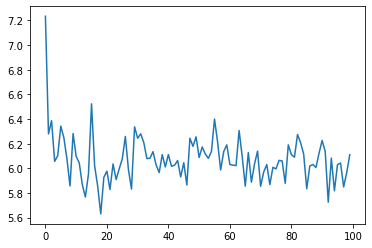

In [ ]:
FR_encoder2 = EncoderRNN(FR_subsets[1]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
FR_attn_decoder2 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  FR_subsets[1]['output_lang'].n_words,
                                  FR_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

FR_plot_losses_2 = trainIters(FR_encoder2,
                              FR_attn_decoder2,
                              FR_subsets[1]['train_pairs'],
                              FR_subsets[1]['input_lang'],
                              FR_subsets[1]['output_lang'],
                              10000,
                              FR_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': FR_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': FR_subsets[1]['input_lang'],
  'output_lang': FR_subsets[1]['output_lang'],
  'encoder': FR_encoder2.state_dict(),
  'attn_decoder': FR_attn_decoder2.state_dict()
}, 'model/FR_10000_S2.pth')

In [ ]:
checkpoint = torch.load('model/FR_10000_S2.pth')
FR_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
FR_subsets[1]['input_lang'] = checkpoint['input_lang']
FR_subsets[1]['output_lang'] = checkpoint['output_lang']
FR_encoder2 = EncoderRNN(FR_subsets[1]['input_lang'].n_words, hidden_size, embedding_size).to(device)
FR_attn_decoder2 = AttnDecoderRNN(hidden_size, embedding_size, FR_subsets[1]['output_lang'].n_words, FR_MAX_LENGTH, dropout_p=0.0).to(device)
FR_encoder2.load_state_dict(checkpoint['encoder'])
FR_attn_decoder2.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(FR_encoder2, FR_attn_decoder2, FR_subsets[1]['input_lang'], FR_subsets[1]['output_lang'], FR_subsets[1]['train_pairs'], FR_MAX_LENGTH, n = 1)

In [ ]:
FR_BLEU_2 = evaluateBleu(FR_encoder2, FR_attn_decoder2, FR_subsets[1]['input_lang'], FR_subsets[1]['output_lang'], FR_subsets[1]['test_pairs'], FR_MAX_LENGTH)
FR_BLEU_2

0m 42s (- 25m 27s) (1000 2%)
1m 26s (- 24m 53s) (2000 5%)
2m 9s (- 24m 12s) (3000 8%)
2m 49s (- 23m 6s) (4000 10%)
3m 33s (- 22m 29s) (5000 13%)
4m 17s (- 21m 55s) (6000 16%)
5m 0s (- 21m 14s) (7000 19%)
5m 45s (- 20m 35s) (8000 21%)
6m 28s (- 19m 53s) (9000 24%)
7m 11s (- 19m 9s) (10000 27%)
7m 52s (- 18m 21s) (11000 30%)
8m 33s (- 17m 34s) (12000 32%)
9m 13s (- 16m 47s) (13000 35%)
9m 56s (- 16m 4s) (14000 38%)
10m 38s (- 15m 21s) (15000 40%)
11m 22s (- 14m 40s) (16000 43%)
12m 5s (- 13m 58s) (17000 46%)
12m 47s (- 13m 15s) (18000 49%)
13m 29s (- 12m 31s) (19000 51%)
14m 11s (- 11m 48s) (20000 54%)
14m 54s (- 11m 6s) (21000 57%)
15m 35s (- 10m 23s) (22000 60%)
16m 18s (- 9m 40s) (23000 62%)
17m 3s (- 8m 59s) (24000 65%)
17m 45s (- 8m 16s) (25000 68%)
18m 29s (- 7m 34s) (26000 70%)
19m 12s (- 6m 52s) (27000 73%)
19m 55s (- 6m 9s) (28000 76%)
20m 38s (- 5m 26s) (29000 79%)
21m 22s (- 4m 44s) (30000 81%)
22m 6s (- 4m 1s) (31000 84%)
22m 50s (- 3m 19s) (32000 87%)
23m 31s (- 2m 36s) (330

[0.13700216364826437,
 0.03323354240786258,
 0.002341656281776829,
 1.2417970213496923e-79]

### Subset 3

1m 26s (- 12m 56s) (1000 10%) 6.1553
2m 55s (- 11m 42s) (2000 20%) 5.9511
4m 26s (- 10m 20s) (3000 30%) 5.8738
5m 59s (- 8m 59s) (4000 40%) 5.9955
7m 31s (- 7m 31s) (5000 50%) 5.9622
9m 5s (- 6m 3s) (6000 60%) 5.9658
10m 38s (- 4m 33s) (7000 70%) 6.0124
12m 13s (- 3m 3s) (8000 80%) 6.0862
13m 47s (- 1m 31s) (9000 90%) 5.9666
15m 31s (- 0m 0s) (10000 100%) 6.0661


<Figure size 432x288 with 0 Axes>

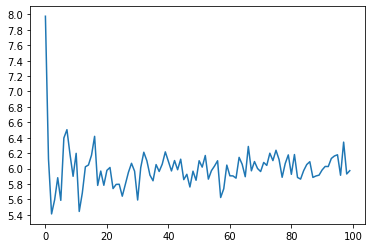

In [ ]:
FR_encoder3 = EncoderRNN(FR_subsets[2]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
FR_attn_decoder3 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  FR_subsets[2]['output_lang'].n_words,
                                  FR_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

FR_plot_losses_3 = trainIters(FR_encoder3,
                              FR_attn_decoder3,
                              FR_subsets[2]['train_pairs'],
                              FR_subsets[2]['input_lang'],
                              FR_subsets[2]['output_lang'],
                              10000,
                              FR_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': FR_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': FR_subsets[2]['input_lang'],
  'output_lang': FR_subsets[2]['output_lang'],
  'encoder': FR_encoder3.state_dict(),
  'attn_decoder': FR_attn_decoder3.state_dict()
}, 'model/FR_10000_S3.pth')

In [ ]:
checkpoint = torch.load('model/FR_10000_S3.pth')
FR_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
FR_subsets[2]['input_lang'] = checkpoint['input_lang']
FR_subsets[2]['output_lang'] = checkpoint['output_lang']
FR_encoder3 = EncoderRNN(FR_subsets[2]['input_lang'].n_words, hidden_size, embedding_size).to(device)
FR_attn_decoder3 = AttnDecoderRNN(hidden_size, embedding_size, FR_subsets[2]['output_lang'].n_words, FR_MAX_LENGTH, dropout_p=0.0).to(device)
FR_encoder3.load_state_dict(checkpoint['encoder'])
FR_attn_decoder3.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(FR_encoder3, FR_attn_decoder3, FR_subsets[2]['input_lang'], FR_subsets[2]['output_lang'], FR_subsets[2]['train_pairs'], FR_MAX_LENGTH, n = 1)

In [ ]:
FR_BLEU_3 = evaluateBleu(FR_encoder3, FR_attn_decoder3, FR_subsets[2]['input_lang'], FR_subsets[2]['output_lang'], FR_subsets[2]['test_pairs'], FR_MAX_LENGTH)
FR_BLEU_3

0m 29s (- 17m 49s) (1000 2%)
0m 59s (- 17m 11s) (2000 5%)
1m 30s (- 16m 54s) (3000 8%)
2m 0s (- 16m 27s) (4000 10%)
2m 31s (- 15m 59s) (5000 13%)
3m 3s (- 15m 37s) (6000 16%)
3m 34s (- 15m 7s) (7000 19%)
4m 7s (- 14m 47s) (8000 21%)
4m 40s (- 14m 21s) (9000 24%)
5m 14s (- 13m 58s) (10000 27%)
5m 46s (- 13m 27s) (11000 30%)
6m 16s (- 12m 54s) (12000 32%)
6m 49s (- 12m 24s) (13000 35%)
7m 21s (- 11m 53s) (14000 38%)
7m 52s (- 11m 22s) (15000 40%)
8m 24s (- 10m 51s) (16000 43%)
8m 54s (- 10m 17s) (17000 46%)
9m 24s (- 9m 45s) (18000 49%)
9m 55s (- 9m 13s) (19000 51%)
10m 25s (- 8m 41s) (20000 54%)
10m 58s (- 8m 10s) (21000 57%)
11m 30s (- 7m 39s) (22000 60%)
11m 59s (- 7m 7s) (23000 62%)
12m 31s (- 6m 35s) (24000 65%)
13m 2s (- 6m 4s) (25000 68%)
13m 31s (- 5m 32s) (26000 70%)
14m 2s (- 5m 1s) (27000 73%)
14m 30s (- 4m 28s) (28000 76%)
14m 59s (- 3m 57s) (29000 79%)
15m 30s (- 3m 26s) (30000 81%)
16m 1s (- 2m 55s) (31000 84%)
16m 31s (- 2m 24s) (32000 87%)
17m 3s (- 1m 53s) (33000 90%)
17

[0.09825464703740479,
 0.026269113691183767,
 0.0012598502270323802,
 6.7388930027991586e-80]

### Subset 4

1m 29s (- 13m 29s) (1000 10%) 6.1572
2m 57s (- 11m 50s) (2000 20%) 5.9881
4m 30s (- 10m 31s) (3000 30%) 6.1784
6m 5s (- 9m 8s) (4000 40%) 6.1110
7m 43s (- 7m 43s) (5000 50%) 6.1983
9m 19s (- 6m 13s) (6000 60%) 6.1223
10m 58s (- 4m 42s) (7000 70%) 6.1478
12m 39s (- 3m 9s) (8000 80%) 6.1273
14m 16s (- 1m 35s) (9000 90%) 6.0495
15m 56s (- 0m 0s) (10000 100%) 6.1321


<Figure size 432x288 with 0 Axes>

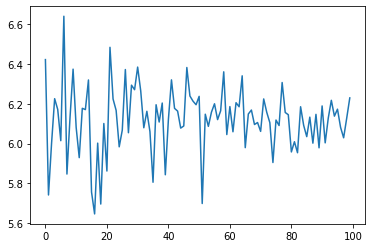

In [ ]:
FR_encoder4 = EncoderRNN(FR_subsets[3]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
FR_attn_decoder4 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  FR_subsets[3]['output_lang'].n_words,
                                  FR_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

FR_plot_losses_4 = trainIters(FR_encoder4,
                              FR_attn_decoder4,
                              FR_subsets[3]['train_pairs'],
                              FR_subsets[3]['input_lang'],
                              FR_subsets[3]['output_lang'],
                              10000,
                              FR_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': FR_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': FR_subsets[3]['input_lang'],
  'output_lang': FR_subsets[3]['output_lang'],
  'encoder': FR_encoder4.state_dict(),
  'attn_decoder': FR_attn_decoder4.state_dict()
}, 'model/FR_10000_S4.pth')

In [ ]:
checkpoint = torch.load('model/FR_10000_S4.pth')
FR_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
FR_subsets[3]['input_lang'] = checkpoint['input_lang']
FR_subsets[3]['output_lang'] = checkpoint['output_lang']
FR_encoder4 = EncoderRNN(FR_subsets[3]['input_lang'].n_words, hidden_size, embedding_size).to(device)
FR_attn_decoder4 = AttnDecoderRNN(hidden_size, embedding_size, FR_subsets[3]['output_lang'].n_words, FR_MAX_LENGTH, dropout_p=0.0).to(device)
FR_encoder4.load_state_dict(checkpoint['encoder'])
FR_attn_decoder4.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(FR_encoder4, FR_attn_decoder4, FR_subsets[3]['input_lang'], FR_subsets[3]['output_lang'], FR_subsets[3]['train_pairs'], FR_MAX_LENGTH, n = 1)

In [ ]:
FR_BLEU_4 = evaluateBleu(FR_encoder4, FR_attn_decoder4, FR_subsets[3]['input_lang'], FR_subsets[3]['output_lang'], FR_subsets[3]['test_pairs'], FR_MAX_LENGTH)
FR_BLEU_4

0m 34s (- 20m 15s) (1000 2%)
1m 6s (- 19m 7s) (2000 5%)
1m 41s (- 18m 54s) (3000 8%)
2m 16s (- 18m 34s) (4000 10%)
2m 51s (- 18m 7s) (5000 13%)
3m 26s (- 17m 36s) (6000 16%)
4m 0s (- 16m 59s) (7000 19%)
4m 36s (- 16m 29s) (8000 21%)
5m 9s (- 15m 50s) (9000 24%)
5m 44s (- 15m 17s) (10000 27%)
6m 18s (- 14m 42s) (11000 30%)
6m 52s (- 14m 7s) (12000 32%)
7m 26s (- 13m 32s) (13000 35%)
8m 1s (- 12m 58s) (14000 38%)
8m 37s (- 12m 26s) (15000 40%)
9m 11s (- 11m 52s) (16000 43%)
9m 45s (- 11m 16s) (17000 46%)
10m 19s (- 10m 41s) (18000 49%)
10m 53s (- 10m 6s) (19000 51%)
11m 28s (- 9m 32s) (20000 54%)
12m 2s (- 8m 58s) (21000 57%)
12m 35s (- 8m 23s) (22000 60%)
13m 10s (- 7m 49s) (23000 62%)
13m 45s (- 7m 15s) (24000 65%)
14m 19s (- 6m 40s) (25000 68%)
14m 54s (- 6m 6s) (26000 70%)
15m 29s (- 5m 32s) (27000 73%)
16m 5s (- 4m 58s) (28000 76%)
16m 39s (- 4m 23s) (29000 79%)
17m 14s (- 3m 49s) (30000 81%)
17m 48s (- 3m 14s) (31000 84%)
18m 24s (- 2m 40s) (32000 87%)
18m 59s (- 2m 6s) (33000 90%)

[0.10596269602031409,
 0.020097700097462992,
 0.0008531808735832386,
 5.356091104766489e-80]

### Subset 5

1m 32s (- 13m 56s) (1000 10%) 6.2304
3m 5s (- 12m 23s) (2000 20%) 6.1335
4m 42s (- 11m 0s) (3000 30%) 5.8749
6m 26s (- 9m 39s) (4000 40%) 5.9423
8m 5s (- 8m 5s) (5000 50%) 6.0144
9m 57s (- 6m 38s) (6000 60%) 6.0345
11m 48s (- 5m 3s) (7000 70%) 5.9965
14m 32s (- 3m 38s) (8000 80%) 6.0036
17m 25s (- 1m 56s) (9000 90%) 5.9555
20m 30s (- 0m 0s) (10000 100%) 5.9347


<Figure size 432x288 with 0 Axes>

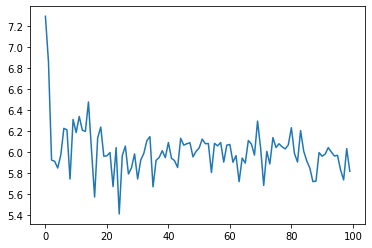

In [ ]:
FR_encoder5 = EncoderRNN(FR_subsets[4]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
FR_attn_decoder5 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  FR_subsets[4]['output_lang'].n_words,
                                  FR_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

FR_plot_losses_5 = trainIters(FR_encoder5,
                              FR_attn_decoder5,
                              FR_subsets[4]['train_pairs'],
                              FR_subsets[4]['input_lang'],
                              FR_subsets[4]['output_lang'],
                              10000,
                              FR_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': FR_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': FR_subsets[4]['input_lang'],
  'output_lang': FR_subsets[4]['output_lang'],
  'encoder': FR_encoder5.state_dict(),
  'attn_decoder': FR_attn_decoder5.state_dict()
}, 'model/FR_10000_S5.pth')

In [ ]:
checkpoint = torch.load('model/FR_10000_S5.pth')
FR_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
FR_subsets[4]['input_lang'] = checkpoint['input_lang']
FR_subsets[4]['output_lang'] = checkpoint['output_lang']
FR_encoder5 = EncoderRNN(FR_subsets[4]['input_lang'].n_words, hidden_size, embedding_size).to(device)
FR_attn_decoder5 = AttnDecoderRNN(hidden_size, embedding_size, FR_subsets[4]['output_lang'].n_words, FR_MAX_LENGTH, dropout_p=0.0).to(device)
FR_encoder5.load_state_dict(checkpoint['encoder'])
FR_attn_decoder5.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(FR_encoder5, FR_attn_decoder5, FR_subsets[4]['input_lang'], FR_subsets[4]['output_lang'], FR_subsets[4]['train_pairs'], FR_MAX_LENGTH, n = 1)

In [ ]:
FR_BLEU_5 = evaluateBleu(FR_encoder5, FR_attn_decoder5, FR_subsets[4]['input_lang'], FR_subsets[4]['output_lang'], FR_subsets[4]['test_pairs'], FR_MAX_LENGTH)
FR_BLEU_5

0m 28s (- 17m 2s) (1000 2%)
0m 59s (- 17m 3s) (2000 5%)
1m 30s (- 16m 52s) (3000 8%)
1m 59s (- 16m 18s) (4000 10%)
2m 29s (- 15m 44s) (5000 13%)
2m 59s (- 15m 15s) (6000 16%)
3m 29s (- 14m 48s) (7000 19%)
3m 59s (- 14m 19s) (8000 21%)
4m 30s (- 13m 51s) (9000 24%)
5m 1s (- 13m 24s) (10000 27%)
5m 33s (- 12m 56s) (11000 30%)
6m 4s (- 12m 27s) (12000 32%)
6m 34s (- 11m 57s) (13000 35%)
7m 2s (- 11m 24s) (14000 38%)
7m 33s (- 10m 54s) (15000 40%)
8m 4s (- 10m 24s) (16000 43%)
8m 35s (- 9m 55s) (17000 46%)
9m 5s (- 9m 24s) (18000 49%)
9m 36s (- 8m 55s) (19000 51%)
10m 6s (- 8m 24s) (20000 54%)
10m 36s (- 7m 54s) (21000 57%)
11m 6s (- 7m 24s) (22000 60%)
11m 37s (- 6m 53s) (23000 62%)
12m 6s (- 6m 23s) (24000 65%)
12m 38s (- 5m 53s) (25000 68%)
13m 9s (- 5m 23s) (26000 70%)
13m 40s (- 4m 53s) (27000 73%)
14m 11s (- 4m 23s) (28000 76%)
14m 42s (- 3m 52s) (29000 79%)
15m 12s (- 3m 22s) (30000 81%)
15m 42s (- 2m 51s) (31000 84%)
16m 13s (- 2m 21s) (32000 87%)
16m 44s (- 1m 51s) (33000 90%)
17m

[0.10318392914988318,
 0.025797625417173443,
 0.001242281600104335,
 6.692967350461706e-80]

### Average BLEU

In [ ]:
np.average(np.stack((FR_BLEU_1, FR_BLEU_2, FR_BLEU_3, FR_BLEU_4, FR_BLEU_5)), 0)

array([1.05679131e-01, 2.39247643e-02, 1.30731733e-03, 7.24788183e-80])

## Russian

In [ ]:
RU_MAX_LENGTH = max([len(a.split(' ')) for a,b in RU_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in RU_subsets[0]['test_pairs']]) + 1
embedding_size = 256
hidden_size = 256

### Subset 1

1m 42s (- 15m 23s) (1000 10%) 5.9153
3m 32s (- 14m 8s) (2000 20%) 5.6059
5m 17s (- 12m 21s) (3000 30%) 5.4900
6m 54s (- 10m 21s) (4000 40%) 5.2998
8m 9s (- 8m 9s) (5000 50%) 5.4726
9m 14s (- 6m 9s) (6000 60%) 5.3340
10m 21s (- 4m 26s) (7000 70%) 5.3251
11m 21s (- 2m 50s) (8000 80%) 5.3281
12m 28s (- 1m 23s) (9000 90%) 5.1294
13m 38s (- 0m 0s) (10000 100%) 5.2084


<Figure size 432x288 with 0 Axes>

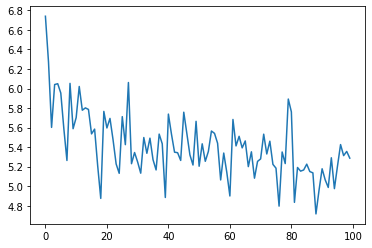

In [ ]:
RU_encoder1 = EncoderRNN(RU_subsets[0]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
RU_attn_decoder1 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  RU_subsets[0]['output_lang'].n_words,
                                  RU_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

RU_plot_losses_1 = trainIters(RU_encoder1,
                              RU_attn_decoder1,
                              RU_subsets[0]['train_pairs'],
                              RU_subsets[0]['input_lang'],
                              RU_subsets[0]['output_lang'],
                              10000,
                              RU_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': RU_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': RU_subsets[0]['input_lang'],
  'output_lang': RU_subsets[0]['output_lang'],
  'encoder': RU_encoder1.state_dict(),
  'attn_decoder': RU_attn_decoder1.state_dict()
}, 'model/RU_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/RU_10000_S1.pth')
RU_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
RU_subsets[0]['input_lang'] = checkpoint['input_lang']
RU_subsets[0]['output_lang'] = checkpoint['output_lang']
RU_encoder1 = EncoderRNN(RU_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
RU_attn_decoder1 = AttnDecoderRNN(hidden_size, embedding_size, RU_subsets[0]['output_lang'].n_words, RU_MAX_LENGTH, dropout_p=0.0).to(device)
RU_encoder1.load_state_dict(checkpoint['encoder'])
RU_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(RU_encoder1, RU_attn_decoder1, RU_subsets[0]['input_lang'], RU_subsets[0]['output_lang'], RU_subsets[0]['test_pairs'], RU_MAX_LENGTH, n = 1)

In [ ]:
RU_BLEU_1 = evaluateBleu(RU_encoder1,
                         RU_attn_decoder1,
                         RU_subsets[0]['input_lang'],
                         RU_subsets[0]['output_lang'],
                         RU_subsets[0]['test_pairs'],
                         RU_MAX_LENGTH)
RU_BLEU_1

0m 17s (- 9m 9s) (1000 3%)
0m 34s (- 8m 52s) (2000 6%)
0m 51s (- 8m 35s) (3000 9%)
1m 8s (- 8m 20s) (4000 12%)
1m 25s (- 8m 3s) (5000 15%)
1m 43s (- 7m 45s) (6000 18%)
2m 0s (- 7m 28s) (7000 21%)
2m 17s (- 7m 13s) (8000 24%)
2m 35s (- 6m 57s) (9000 27%)
2m 52s (- 6m 39s) (10000 30%)
3m 10s (- 6m 22s) (11000 33%)
3m 27s (- 6m 4s) (12000 36%)
3m 44s (- 5m 47s) (13000 39%)
4m 1s (- 5m 29s) (14000 42%)
4m 18s (- 5m 12s) (15000 45%)
4m 35s (- 4m 55s) (16000 48%)
4m 52s (- 4m 37s) (17000 51%)
5m 10s (- 4m 20s) (18000 54%)
5m 27s (- 4m 3s) (19000 57%)
5m 44s (- 3m 45s) (20000 60%)
6m 1s (- 3m 28s) (21000 63%)
6m 18s (- 3m 11s) (22000 66%)
6m 35s (- 2m 54s) (23000 69%)
6m 52s (- 2m 36s) (24000 72%)
7m 10s (- 2m 19s) (25000 75%)
7m 27s (- 2m 2s) (26000 78%)
7m 44s (- 1m 45s) (27000 81%)
8m 2s (- 1m 28s) (28000 84%)
8m 19s (- 1m 11s) (29000 87%)
8m 37s (- 0m 53s) (30000 90%)
8m 53s (- 0m 36s) (31000 93%)
9m 11s (- 0m 19s) (32000 96%)
9m 28s (- 0m 2s) (33000 99%)
9m 30s (- 0m 0s) (33119 100%)


[0.0904832426016131,
 0.025626978493707448,
 0.0022584836722688174,
 9.855262288814669e-80]

In [ ]:
RU_BEAM_1 = evaluateBleu_beam_search(RU_encoder1, RU_attn_decoder1, RU_subsets[0]['input_lang'], RU_subsets[0]['output_lang'], RU_subsets[0]['test_pairs'], RU_MAX_LENGTH, 4)
RU_BEAM_1

5m 44s (- 184m 18s) (1000 3%)
11m 32s (- 179m 40s) (2000 6%)
17m 18s (- 173m 44s) (3000 9%)
23m 10s (- 168m 41s) (4000 12%)
29m 2s (- 163m 22s) (5000 15%)
34m 50s (- 157m 29s) (6000 18%)
40m 41s (- 151m 48s) (7000 21%)
46m 39s (- 146m 31s) (8000 24%)
52m 41s (- 141m 12s) (9000 27%)
58m 25s (- 135m 5s) (10000 30%)
64m 33s (- 129m 48s) (11000 33%)
71m 3s (- 125m 3s) (12000 36%)
77m 39s (- 120m 12s) (13000 39%)
84m 12s (- 114m 59s) (14000 42%)
90m 50s (- 109m 44s) (15000 45%)
97m 31s (- 104m 21s) (16000 48%)
103m 59s (- 98m 36s) (17000 51%)
110m 35s (- 92m 54s) (18000 54%)
116m 48s (- 86m 48s) (19000 57%)
123m 14s (- 80m 50s) (20000 60%)
129m 41s (- 74m 50s) (21000 63%)
136m 10s (- 68m 50s) (22000 66%)
142m 7s (- 62m 31s) (23000 69%)
148m 4s (- 56m 16s) (24000 72%)
154m 7s (- 50m 3s) (25000 75%)
159m 50s (- 43m 46s) (26000 78%)
165m 37s (- 37m 32s) (27000 81%)
171m 29s (- 31m 21s) (28000 84%)
177m 27s (- 25m 12s) (29000 87%)
183m 15s (- 19m 3s) (30000 90%)
188m 55s (- 12m 55s) (31000 93%)

[0.08086252173433908,
 0.0233864267011253,
 0.001985612991798911,
 8.306487218923785e-80]

### Subset 2

1m 8s (- 10m 18s) (1000 10%) 5.8903
2m 15s (- 9m 0s) (2000 20%) 5.5064
3m 26s (- 8m 0s) (3000 30%) 5.5569
4m 29s (- 6m 43s) (4000 40%) 5.3873
5m 31s (- 5m 31s) (5000 50%) 5.3639
6m 32s (- 4m 21s) (6000 60%) 5.2359
7m 30s (- 3m 13s) (7000 70%) 5.1016
8m 35s (- 2m 8s) (8000 80%) 5.2700
9m 37s (- 1m 4s) (9000 90%) 5.1808
10m 42s (- 0m 0s) (10000 100%) 5.2945


<Figure size 432x288 with 0 Axes>

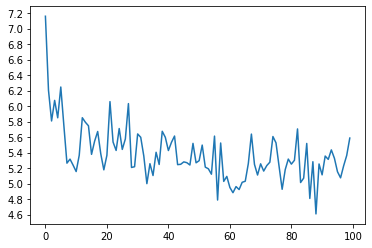

In [ ]:
RU_encoder2 = EncoderRNN(RU_subsets[1]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
RU_attn_decoder2 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  RU_subsets[1]['output_lang'].n_words,
                                  RU_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

RU_plot_losses_2 = trainIters(RU_encoder2,
                              RU_attn_decoder2,
                              RU_subsets[1]['train_pairs'],
                              RU_subsets[1]['input_lang'],
                              RU_subsets[1]['output_lang'],
                              10000,
                              RU_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': RU_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': RU_subsets[1]['input_lang'],
  'output_lang': RU_subsets[1]['output_lang'],
  'encoder': RU_encoder2.state_dict(),
  'attn_decoder': RU_attn_decoder2.state_dict()
}, 'model/RU_10000_S2.pth')

In [ ]:
checkpoint = torch.load('model/RU_10000_S2.pth')
RU_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
RU_subsets[1]['input_lang'] = checkpoint['input_lang']
RU_subsets[1]['output_lang'] = checkpoint['output_lang']
RU_encoder2 = EncoderRNN(RU_subsets[1]['input_lang'].n_words, hidden_size, embedding_size).to(device)
RU_attn_decoder2 = AttnDecoderRNN(hidden_size, embedding_size, RU_subsets[1]['output_lang'].n_words, RU_MAX_LENGTH, dropout_p=0.0).to(device)
RU_encoder2.load_state_dict(checkpoint['encoder'])
RU_attn_decoder2.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(RU_encoder2, RU_attn_decoder2, RU_subsets[1]['input_lang'], RU_subsets[1]['output_lang'], RU_subsets[1]['train_pairs'], RU_MAX_LENGTH, n = 1)

In [ ]:
RU_BLEU_2 = evaluateBleu(RU_encoder2, RU_attn_decoder2, RU_subsets[1]['input_lang'], RU_subsets[1]['output_lang'], RU_subsets[1]['test_pairs'], RU_MAX_LENGTH)
RU_BLEU_2

0m 12s (- 6m 26s) (1000 3%)
0m 24s (- 6m 17s) (2000 6%)
0m 36s (- 6m 6s) (3000 9%)
0m 48s (- 5m 54s) (4000 12%)
1m 0s (- 5m 41s) (5000 15%)
1m 12s (- 5m 29s) (6000 18%)
1m 25s (- 5m 17s) (7000 21%)
1m 37s (- 5m 4s) (8000 24%)
1m 49s (- 4m 52s) (9000 27%)
2m 1s (- 4m 40s) (10000 30%)
2m 13s (- 4m 28s) (11000 33%)
2m 25s (- 4m 16s) (12000 36%)
2m 37s (- 4m 4s) (13000 39%)
2m 50s (- 3m 52s) (14000 42%)
3m 2s (- 3m 40s) (15000 45%)
3m 14s (- 3m 28s) (16000 48%)
3m 26s (- 3m 16s) (17000 51%)
3m 39s (- 3m 4s) (18000 54%)
3m 51s (- 2m 51s) (19000 57%)
4m 3s (- 2m 39s) (20000 60%)
4m 15s (- 2m 27s) (21000 63%)
4m 27s (- 2m 15s) (22000 66%)
4m 39s (- 2m 3s) (23000 69%)
4m 52s (- 1m 50s) (24000 72%)
5m 4s (- 1m 38s) (25000 75%)
5m 16s (- 1m 26s) (26000 78%)
5m 28s (- 1m 14s) (27000 81%)
5m 40s (- 1m 2s) (28000 84%)
5m 52s (- 0m 50s) (29000 87%)
6m 5s (- 0m 37s) (30000 90%)
6m 17s (- 0m 25s) (31000 93%)
6m 29s (- 0m 13s) (32000 96%)
6m 41s (- 0m 1s) (33000 99%)
6m 43s (- 0m 0s) (33119 100%)


[0.06742666514649132,
 0.012218738846637458,
 0.002473850898344968,
 0.0005383945733193906]

### Subset 3

1m 5s (- 9m 46s) (1000 10%) 6.1340
2m 9s (- 8m 38s) (2000 20%) 5.6335
3m 8s (- 7m 20s) (3000 30%) 5.3200
4m 10s (- 6m 15s) (4000 40%) 5.4883
5m 10s (- 5m 10s) (5000 50%) 5.3584
6m 11s (- 4m 7s) (6000 60%) 5.4013
7m 12s (- 3m 5s) (7000 70%) 5.3544
8m 15s (- 2m 3s) (8000 80%) 5.3801
9m 13s (- 1m 1s) (9000 90%) 5.1893
10m 12s (- 0m 0s) (10000 100%) 5.2449


<Figure size 432x288 with 0 Axes>

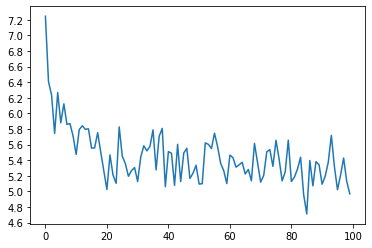

In [ ]:
RU_encoder3 = EncoderRNN(RU_subsets[2]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
RU_attn_decoder3 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  RU_subsets[2]['output_lang'].n_words,
                                  RU_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

RU_plot_losses_3 = trainIters(RU_encoder3,
                              RU_attn_decoder3,
                              RU_subsets[2]['train_pairs'],
                              RU_subsets[2]['input_lang'],
                              RU_subsets[2]['output_lang'],
                              10000,
                              RU_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': RU_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': RU_subsets[2]['input_lang'],
  'output_lang': RU_subsets[2]['output_lang'],
  'encoder': RU_encoder3.state_dict(),
  'attn_decoder': RU_attn_decoder3.state_dict()
}, 'model/RU_10000_S3.pth')

In [ ]:
checkpoint = torch.load('model/RU_10000_S3.pth')
RU_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
RU_subsets[2]['input_lang'] = checkpoint['input_lang']
RU_subsets[2]['output_lang'] = checkpoint['output_lang']
RU_encoder3 = EncoderRNN(RU_subsets[2]['input_lang'].n_words, hidden_size, embedding_size).to(device)
RU_attn_decoder3 = AttnDecoderRNN(hidden_size, embedding_size, RU_subsets[2]['output_lang'].n_words, RU_MAX_LENGTH, dropout_p=0.0).to(device)
RU_encoder3.load_state_dict(checkpoint['encoder'])
RU_attn_decoder3.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(RU_encoder3, RU_attn_decoder3, RU_subsets[2]['input_lang'], RU_subsets[2]['output_lang'], RU_subsets[2]['train_pairs'], RU_MAX_LENGTH, n = 1)

In [ ]:
RU_BLEU_3 = evaluateBleu(RU_encoder3, RU_attn_decoder3, RU_subsets[2]['input_lang'], RU_subsets[2]['output_lang'], RU_subsets[2]['test_pairs'], RU_MAX_LENGTH)
RU_BLEU_3

0m 15s (- 8m 24s) (1000 3%)
0m 31s (- 8m 6s) (2000 6%)
0m 46s (- 7m 50s) (3000 9%)
1m 2s (- 7m 34s) (4000 12%)
1m 17s (- 7m 18s) (5000 15%)
1m 33s (- 7m 2s) (6000 18%)
1m 49s (- 6m 47s) (7000 21%)
2m 4s (- 6m 32s) (8000 24%)
2m 20s (- 6m 15s) (9000 27%)
2m 35s (- 6m 0s) (10000 30%)
2m 51s (- 5m 45s) (11000 33%)
3m 7s (- 5m 29s) (12000 36%)
3m 23s (- 5m 14s) (13000 39%)
3m 38s (- 4m 58s) (14000 42%)
3m 54s (- 4m 42s) (15000 45%)
4m 9s (- 4m 27s) (16000 48%)
4m 25s (- 4m 11s) (17000 51%)
4m 41s (- 3m 56s) (18000 54%)
4m 56s (- 3m 40s) (19000 57%)
5m 12s (- 3m 24s) (20000 60%)
5m 28s (- 3m 9s) (21000 63%)
5m 43s (- 2m 53s) (22000 66%)
5m 59s (- 2m 38s) (23000 69%)
6m 15s (- 2m 22s) (24000 72%)
6m 30s (- 2m 6s) (25000 75%)
6m 45s (- 1m 51s) (26000 78%)
7m 1s (- 1m 35s) (27000 81%)
7m 16s (- 1m 19s) (28000 84%)
7m 32s (- 1m 4s) (29000 87%)
7m 48s (- 0m 48s) (30000 90%)
8m 3s (- 0m 33s) (31000 93%)
8m 19s (- 0m 17s) (32000 96%)
8m 34s (- 0m 1s) (33000 99%)
8m 36s (- 0m 0s) (33119 100%)


[0.09387306994076298,
 0.020826494553856604,
 0.0022016273417748058,
 9.275549114227222e-80]

### Subset 4

1m 1s (- 9m 12s) (1000 10%) 5.8720
2m 0s (- 8m 2s) (2000 20%) 5.6727
2m 57s (- 6m 55s) (3000 30%) 5.4937
3m 54s (- 5m 52s) (4000 40%) 5.2247
4m 54s (- 4m 54s) (5000 50%) 5.3822
5m 53s (- 3m 55s) (6000 60%) 5.2620
6m 53s (- 2m 57s) (7000 70%) 5.3972
7m 54s (- 1m 58s) (8000 80%) 5.3781
8m 55s (- 0m 59s) (9000 90%) 5.2708
9m 56s (- 0m 0s) (10000 100%) 5.2958


<Figure size 432x288 with 0 Axes>

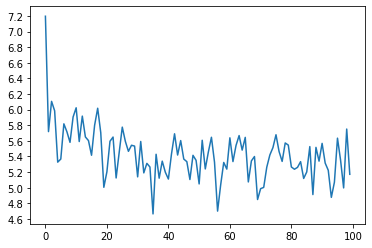

In [ ]:
RU_encoder4 = EncoderRNN(RU_subsets[3]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
RU_attn_decoder4 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  RU_subsets[3]['output_lang'].n_words,
                                  RU_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

RU_plot_losses_4 = trainIters(RU_encoder4,
                              RU_attn_decoder4,
                              RU_subsets[3]['train_pairs'],
                              RU_subsets[3]['input_lang'],
                              RU_subsets[3]['output_lang'],
                              10000,
                              RU_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': RU_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': RU_subsets[3]['input_lang'],
  'output_lang': RU_subsets[3]['output_lang'],
  'encoder': RU_encoder4.state_dict(),
  'attn_decoder': RU_attn_decoder4.state_dict()
}, 'model/RU_10000_S4.pth')

In [ ]:
checkpoint = torch.load('model/RU_10000_S4.pth')
RU_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
RU_subsets[3]['input_lang'] = checkpoint['input_lang']
RU_subsets[3]['output_lang'] = checkpoint['output_lang']
RU_encoder4 = EncoderRNN(RU_subsets[3]['input_lang'].n_words, hidden_size, embedding_size).to(device)
RU_attn_decoder4 = AttnDecoderRNN(hidden_size, embedding_size, RU_subsets[3]['output_lang'].n_words, RU_MAX_LENGTH, dropout_p=0.0).to(device)
RU_encoder4.load_state_dict(checkpoint['encoder'])
RU_attn_decoder4.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(RU_encoder4, RU_attn_decoder4, RU_subsets[3]['input_lang'], RU_subsets[3]['output_lang'], RU_subsets[3]['train_pairs'], RU_MAX_LENGTH, n = 1)

In [ ]:
RU_BLEU_4 = evaluateBleu(RU_encoder4, RU_attn_decoder4, RU_subsets[3]['input_lang'], RU_subsets[3]['output_lang'], RU_subsets[3]['test_pairs'], RU_MAX_LENGTH)
RU_BLEU_4

0m 15s (- 8m 5s) (1000 3%)
0m 30s (- 7m 50s) (2000 6%)
0m 45s (- 7m 32s) (3000 9%)
1m 0s (- 7m 19s) (4000 12%)
1m 15s (- 7m 3s) (5000 15%)
1m 30s (- 6m 48s) (6000 18%)
1m 45s (- 6m 32s) (7000 21%)
2m 0s (- 6m 18s) (8000 24%)
2m 15s (- 6m 3s) (9000 27%)
2m 30s (- 5m 48s) (10000 30%)
2m 45s (- 5m 33s) (11000 33%)
3m 0s (- 5m 18s) (12000 36%)
3m 15s (- 5m 3s) (13000 39%)
3m 31s (- 4m 48s) (14000 42%)
3m 46s (- 4m 33s) (15000 45%)
4m 1s (- 4m 18s) (16000 48%)
4m 16s (- 4m 3s) (17000 51%)
4m 31s (- 3m 48s) (18000 54%)
4m 46s (- 3m 33s) (19000 57%)
5m 2s (- 3m 18s) (20000 60%)
5m 17s (- 3m 3s) (21000 63%)
5m 32s (- 2m 47s) (22000 66%)
5m 47s (- 2m 32s) (23000 69%)
6m 2s (- 2m 17s) (24000 72%)
6m 17s (- 2m 2s) (25000 75%)
6m 32s (- 1m 47s) (26000 78%)
6m 48s (- 1m 32s) (27000 81%)
7m 3s (- 1m 17s) (28000 84%)
7m 18s (- 1m 2s) (29000 87%)
7m 33s (- 0m 47s) (30000 90%)
7m 48s (- 0m 32s) (31000 93%)
8m 4s (- 0m 16s) (32000 96%)
8m 19s (- 0m 1s) (33000 99%)
8m 21s (- 0m 0s) (33119 100%)


[0.08271116275424818,
 0.01056125144082931,
 0.0019375381037997524,
 8.239715343778166e-80]

### Subset 5

1m 3s (- 9m 34s) (1000 10%) 6.0382
2m 6s (- 8m 24s) (2000 20%) 5.5256
3m 3s (- 7m 7s) (3000 30%) 5.3580
4m 6s (- 6m 9s) (4000 40%) 5.5224
5m 10s (- 5m 10s) (5000 50%) 5.3226
6m 6s (- 4m 4s) (6000 60%) 5.1835
7m 7s (- 3m 3s) (7000 70%) 5.2561
8m 12s (- 2m 3s) (8000 80%) 5.4230
9m 16s (- 1m 1s) (9000 90%) 5.4338
10m 20s (- 0m 0s) (10000 100%) 5.3694


<Figure size 432x288 with 0 Axes>

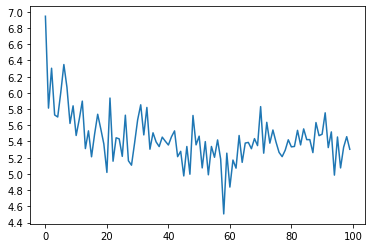

In [ ]:
RU_encoder5 = EncoderRNN(RU_subsets[4]['input_lang'].n_words,
                         hidden_size,
                         embedding_size).to(device)
RU_attn_decoder5 = AttnDecoderRNN(hidden_size,
                                  embedding_size,
                                  RU_subsets[4]['output_lang'].n_words,
                                  RU_MAX_LENGTH,
                                  dropout_p=0.0).to(device)

RU_plot_losses_5 = trainIters(RU_encoder5,
                              RU_attn_decoder5,
                              RU_subsets[4]['train_pairs'],
                              RU_subsets[4]['input_lang'],
                              RU_subsets[4]['output_lang'],
                              10000,
                              RU_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': RU_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': RU_subsets[4]['input_lang'],
  'output_lang': RU_subsets[4]['output_lang'],
  'encoder': RU_encoder5.state_dict(),
  'attn_decoder': RU_attn_decoder5.state_dict()
}, 'model/RU_10000_S5.pth')

In [ ]:
checkpoint = torch.load('model/RU_10000_S5.pth')
RU_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
RU_subsets[4]['input_lang'] = checkpoint['input_lang']
RU_subsets[4]['output_lang'] = checkpoint['output_lang']
RU_encoder5 = EncoderRNN(RU_subsets[4]['input_lang'].n_words, hidden_size, embedding_size).to(device)
RU_attn_decoder5 = AttnDecoderRNN(hidden_size, embedding_size, RU_subsets[4]['output_lang'].n_words, RU_MAX_LENGTH, dropout_p=0.0).to(device)
RU_encoder5.load_state_dict(checkpoint['encoder'])
RU_attn_decoder5.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(RU_encoder5, RU_attn_decoder5, RU_subsets[4]['input_lang'], RU_subsets[4]['output_lang'], RU_subsets[4]['train_pairs'], RU_MAX_LENGTH, n = 1)

In [ ]:
RU_BLEU_5 = evaluateBleu(RU_encoder5, RU_attn_decoder5, RU_subsets[4]['input_lang'], RU_subsets[4]['output_lang'], RU_subsets[4]['test_pairs'], RU_MAX_LENGTH)
RU_BLEU_5

0m 22s (- 11m 54s) (1000 3%)
0m 44s (- 11m 30s) (2000 6%)
1m 6s (- 11m 8s) (3000 9%)
1m 28s (- 10m 46s) (4000 12%)
1m 51s (- 10m 24s) (5000 15%)
2m 13s (- 10m 2s) (6000 18%)
2m 35s (- 9m 39s) (7000 21%)
2m 57s (- 9m 17s) (8000 24%)
3m 19s (- 8m 54s) (9000 27%)
3m 41s (- 8m 31s) (10000 30%)
4m 3s (- 8m 10s) (11000 33%)
4m 26s (- 7m 48s) (12000 36%)
4m 48s (- 7m 26s) (13000 39%)
5m 10s (- 7m 3s) (14000 42%)
5m 32s (- 6m 41s) (15000 45%)
5m 54s (- 6m 19s) (16000 48%)
6m 17s (- 5m 57s) (17000 51%)
6m 38s (- 5m 35s) (18000 54%)
7m 1s (- 5m 12s) (19000 57%)
7m 22s (- 4m 50s) (20000 60%)
7m 45s (- 4m 28s) (21000 63%)
8m 8s (- 4m 6s) (22000 66%)
8m 29s (- 3m 44s) (23000 69%)
8m 52s (- 3m 22s) (24000 72%)
9m 14s (- 2m 59s) (25000 75%)
9m 36s (- 2m 37s) (26000 78%)
9m 58s (- 2m 15s) (27000 81%)
10m 19s (- 1m 53s) (28000 84%)
10m 42s (- 1m 31s) (29000 87%)
11m 4s (- 1m 9s) (30000 90%)
11m 26s (- 0m 47s) (31000 93%)
11m 48s (- 0m 24s) (32000 96%)
12m 10s (- 0m 2s) (33000 99%)
12m 13s (- 0m 0s) (33

[0.10947957039816572,
 0.023400830638471058,
 0.0019193167297556107,
 0.00030374814370619474]

### Average BLEU

In [ ]:
np.average(np.stack((RU_BLEU_1, RU_BLEU_2, RU_BLEU_3, RU_BLEU_4, RU_BLEU_5)), 0)

array([0.08879474, 0.01852686, 0.00215816, 0.00016843])

# Question 2bi.

There are a few differences in which the AttnDecoderRNN of tutorial 6 defers from the attention decoder of lecture 6.

Firstly, the attention decoder of lecture 6 at each decoding step uses the decoder hidden state after passing through the gated recurrent unit layer for computation of the attention scores.  
However, the attention decoder of the tutorial computes the attention scores and output before passing through the GRU layer, and as such uses the initial decoder hidden state at each decoding step instead.

We see that the attention weights and outputs are calculated first:
```Python
attn_weights = F.softmax(
    self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                         encoder_outputs.unsqueeze(0))
```
Before the intermediate outputs are passed to the GRU layer:
```Python
output = torch.cat((embedded[0], attn_applied[0]), 1)
output = self.attn_combine(output).unsqueeze(0)

output = F.relu(output)
output, hidden = self.gru(output, hidden)
```

---
Secondly, for calculation of the attention score, the attention decoder of lecture 6 only uses encoder and decoder hidden states for computation of the attention scores, while the attention decoder of the tutorial also uses the input word embedding along with the decoder hidden state to get the intermediate attention scores.

Here we see the attention scores computed by concatenating the input embeddings with initial hidden state, and multiplying them with a trainable weight matrix *self.attn* before taking the softmax of the intermediate output to give the attention scores:
```Python
attn_weights = F.softmax(
    self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
```
---
Thirdly, the attention decoder of lecture 6 takes the softmax of the matrix multiplication between the decoder and encoder hidden states as the attention distribution, which is the simple dot-product score described in Luong2015, with no trainable weights.

However, the attention decoder of tutorial 6 has two trainable linear weight matrixes, the first weight matrix, *self.attn*, is for transforming the concatenated input embedding and initial hidden state, while the second weight matrix, *self.attn_combine*, is for tranforming the concatenation of the input embedding and the intermediate attention outputs (after multiplying the first attention scores with the encoder hidden states).

First linear transformation:
```Python
attn_weights = F.softmax(
    self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
```

Second linear transformation:
```Python
output = torch.cat((embedded[0], attn_applied[0]), 1)
output = self.attn_combine(output).unsqueeze(0)
```

---
The 2 attention decoders are similar in that they do not use the previous step attention outputs at each decoding step for token generation through the GRU layer, though the AttnDecoderRNN of tutorial 6 does return the attn_weights at the end of the forward() function. Supposing we perform attention step after the GRU layer, it should be possible to use the previous attention weights or outputs as additional features for the GRU layer, on top of using the current attention outputs for the final linear layer, as shown in the AttnDecoderRNN here: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb

# Question 2bii.

In [ ]:
class LectureAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, dropout_p=0.1):
        super(LectureAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)

        output, hidden = self.gru(output, hidden)
        # Attention scores are the softmax of the simple dot-product
        # between encoder and decoder hidden states.
        # FOR UNIDIRECTIONAL GRU HERE, OUTPUT AND HIDDEN RETURN TENSORS ARE THE SAME.
        attn_weights = torch.bmm(encoder_outputs.unsqueeze(0),
                                  output.view(1,-1,1)
                                 ).view(1,-1)
        attn_weights = F.softmax(attn_weights, dim=1)
        # Attention output is attention scores multiplied by encoder hidden states
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # Attention outputs are concatenated with decoder hidden states at the end
        output = torch.cat((attn_applied[0], output[0]), 1)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
DE_MAX_LENGTH = max([len(a.split(' ')) for a,b in DE_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in DE_subsets[0]['test_pairs']]) + 1
embedding_size = 256
hidden_size = 256

1m 50s (- 16m 30s) (1000 10%) 6.2431
3m 35s (- 14m 21s) (2000 20%) 5.6948
5m 20s (- 12m 26s) (3000 30%) 5.6267
7m 5s (- 10m 38s) (4000 40%) 5.5017
8m 49s (- 8m 49s) (5000 50%) 5.3026
10m 39s (- 7m 6s) (6000 60%) 5.4736
12m 31s (- 5m 22s) (7000 70%) 5.5618
14m 18s (- 3m 34s) (8000 80%) 5.6025
16m 9s (- 1m 47s) (9000 90%) 5.5943
17m 59s (- 0m 0s) (10000 100%) 5.5911


<Figure size 432x288 with 0 Axes>

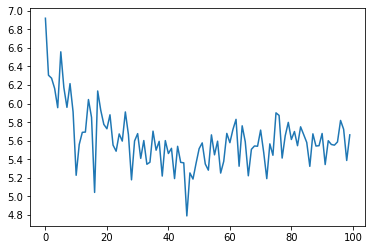

In [ ]:
L_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words,
                        hidden_size,
                        embedding_size).to(device)
L_attn_decoder1 = LectureAttnDecoderRNN(hidden_size,
                                        embedding_size,
                                        DE_subsets[0]['output_lang'].n_words,
                                        dropout_p=0.0).to(device)

L_plot_losses_1 = trainIters(L_encoder1,
                             L_attn_decoder1,
                             DE_subsets[0]['train_pairs'],
                             DE_subsets[0]['input_lang'],
                             DE_subsets[0]['output_lang'],
                             10000,
                             DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[0]['input_lang'],
  'output_lang': DE_subsets[0]['output_lang'],
  'encoder': L_encoder1.state_dict(),
  'attn_decoder': L_attn_decoder1.state_dict()
}, 'model/L_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/L_10000_S1.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[0]['input_lang'] = checkpoint['input_lang']
DE_subsets[0]['output_lang'] = checkpoint['output_lang']
L_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
L_attn_decoder1 = LectureAttnDecoderRNN(hidden_size, embedding_size, DE_subsets[0]['output_lang'].n_words, dropout_p=0.0).to(device)
L_encoder1.load_state_dict(checkpoint['encoder'])
L_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(L_encoder1, L_attn_decoder1, DE_subsets[0]['input_lang'], DE_subsets[0]['output_lang'], DE_subsets[0]['test_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
L_BLEU_1 = evaluateBleu(L_encoder1,
                        L_attn_decoder1,
                        DE_subsets[0]['input_lang'],
                        DE_subsets[0]['output_lang'],
                        DE_subsets[0]['test_pairs'],
                        DE_MAX_LENGTH)
L_BLEU_1

0m 31s (- 20m 35s) (1000 2%)
1m 3s (- 20m 13s) (2000 4%)
1m 35s (- 19m 45s) (3000 7%)
2m 5s (- 18m 56s) (4000 9%)
2m 35s (- 18m 16s) (5000 12%)
3m 5s (- 17m 41s) (6000 14%)
3m 36s (- 17m 9s) (7000 17%)
4m 5s (- 16m 30s) (8000 19%)
4m 32s (- 15m 47s) (9000 22%)
5m 2s (- 15m 15s) (10000 24%)
5m 31s (- 14m 42s) (11000 27%)
6m 0s (- 14m 8s) (12000 29%)
6m 30s (- 13m 39s) (13000 32%)
7m 0s (- 13m 9s) (14000 34%)
7m 32s (- 12m 42s) (15000 37%)
8m 2s (- 12m 11s) (16000 39%)
8m 32s (- 11m 40s) (17000 42%)
9m 2s (- 11m 10s) (18000 44%)
9m 32s (- 10m 40s) (19000 47%)
10m 2s (- 10m 9s) (20000 49%)
10m 32s (- 9m 40s) (21000 52%)
11m 2s (- 9m 10s) (22000 54%)
11m 31s (- 8m 39s) (23000 57%)
11m 59s (- 8m 7s) (24000 59%)
12m 29s (- 7m 37s) (25000 62%)
12m 58s (- 7m 6s) (26000 64%)
13m 28s (- 6m 36s) (27000 67%)
13m 58s (- 6m 7s) (28000 69%)
14m 28s (- 5m 37s) (29000 72%)
14m 52s (- 5m 5s) (30000 74%)
15m 22s (- 4m 35s) (31000 77%)
15m 52s (- 4m 5s) (32000 79%)
16m 22s (- 3m 36s) (33000 81%)
16m 52s (

[0.17642394422265412,
 0.04700577944264107,
 0.008562764428953182,
 0.0014762478722133425]

# Question 2biii.

## Multiplicative Attention

In [ ]:
class MultiplicativeAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, dropout_p=0.1):
        super(MultiplicativeAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.attn_W = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)

        output, hidden = self.gru(output, hidden)
        # Attention scores are the encoder hidden states multiplied by the
        # dot product between the weight matrix and the decoder hidden states.
        # FOR UNIDIRECTIONAL GRU HERE, OUTPUT AND HIDDEN RETURN TENSORS ARE THE SAME.
        attn_weights = self.attn_W(output)
        attn_weights = torch.bmm(encoder_outputs.unsqueeze(0),
                                  output.view(1,-1,1)
                                 ).view(1,-1)
        attn_weights = F.softmax(attn_weights, dim=1)
        # Attention output is attention scores multiplied by encoder hidden states
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # Attention outputs are concatenated with decoder hidden states at the end
        output = torch.cat((attn_applied[0], output[0]), 1)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
DE_MAX_LENGTH = max([len(a.split(' ')) for a,b in DE_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in DE_subsets[0]['test_pairs']]) + 1
embedding_size = 256
hidden_size = 256

1m 51s (- 16m 42s) (1000 10%) 6.2685
3m 45s (- 15m 0s) (2000 20%) 5.8841
5m 34s (- 13m 0s) (3000 30%) 5.5778
7m 24s (- 11m 6s) (4000 40%) 5.7190
9m 16s (- 9m 16s) (5000 50%) 5.6812
11m 11s (- 7m 27s) (6000 60%) 5.7026
13m 9s (- 5m 38s) (7000 70%) 5.6985
15m 8s (- 3m 47s) (8000 80%) 5.8270
17m 3s (- 1m 53s) (9000 90%) 5.6932
19m 3s (- 0m 0s) (10000 100%) 5.6531


<Figure size 432x288 with 0 Axes>

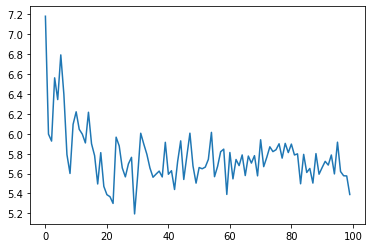

In [ ]:
M_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words,
                        hidden_size,
                        embedding_size).to(device)
M_attn_decoder1 = MultiplicativeAttnDecoderRNN(hidden_size,
                                               embedding_size,
                                               DE_subsets[0]['output_lang'].n_words,
                                               dropout_p=0.0).to(device)

M_plot_losses_1 = trainIters(M_encoder1,
                             M_attn_decoder1,
                             DE_subsets[0]['train_pairs'],
                             DE_subsets[0]['input_lang'],
                             DE_subsets[0]['output_lang'],
                             10000,
                             DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[0]['input_lang'],
  'output_lang': DE_subsets[0]['output_lang'],
  'encoder': M_encoder1.state_dict(),
  'attn_decoder': M_attn_decoder1.state_dict()
}, 'model/M_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/M_10000_S1.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[0]['input_lang'] = checkpoint['input_lang']
DE_subsets[0]['output_lang'] = checkpoint['output_lang']
M_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
M_attn_decoder1 = MultiplicativeAttnDecoderRNN(hidden_size, embedding_size, DE_subsets[0]['output_lang'].n_words, dropout_p=0.0).to(device)
M_encoder1.load_state_dict(checkpoint['encoder'])
M_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(M_encoder1, M_attn_decoder1, DE_subsets[0]['input_lang'], DE_subsets[0]['output_lang'], DE_subsets[0]['test_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
M_BLEU_1 = evaluateBleu(M_encoder1,
                        M_attn_decoder1,
                        DE_subsets[0]['input_lang'],
                        DE_subsets[0]['output_lang'],
                        DE_subsets[0]['test_pairs'],
                        DE_MAX_LENGTH)
M_BLEU_1

0m 35s (- 23m 14s) (1000 2%)
1m 11s (- 22m 39s) (2000 4%)
1m 47s (- 22m 10s) (3000 7%)
2m 23s (- 21m 37s) (4000 9%)
2m 59s (- 21m 5s) (5000 12%)
3m 36s (- 20m 34s) (6000 14%)
4m 13s (- 20m 5s) (7000 17%)
4m 49s (- 19m 26s) (8000 19%)
5m 22s (- 18m 39s) (9000 22%)
5m 58s (- 18m 5s) (10000 24%)
6m 33s (- 17m 27s) (11000 27%)
7m 8s (- 16m 48s) (12000 29%)
7m 45s (- 16m 16s) (13000 32%)
8m 22s (- 15m 42s) (14000 34%)
9m 1s (- 15m 11s) (15000 37%)
9m 38s (- 14m 36s) (16000 39%)
10m 14s (- 14m 0s) (17000 42%)
10m 51s (- 13m 25s) (18000 44%)
11m 26s (- 12m 47s) (19000 47%)
12m 2s (- 12m 11s) (20000 49%)
12m 38s (- 11m 35s) (21000 52%)
13m 17s (- 11m 1s) (22000 54%)
13m 54s (- 10m 26s) (23000 57%)
14m 29s (- 9m 49s) (24000 59%)
15m 8s (- 9m 14s) (25000 62%)
15m 43s (- 8m 37s) (26000 64%)
16m 20s (- 8m 1s) (27000 67%)
16m 57s (- 7m 25s) (28000 69%)
17m 33s (- 6m 49s) (29000 72%)
18m 1s (- 6m 9s) (30000 74%)
18m 36s (- 5m 33s) (31000 77%)
19m 13s (- 4m 57s) (32000 79%)
19m 50s (- 4m 21s) (33000 

[0.19035445225605216,
 0.05332326947939018,
 0.016476391663392476,
 0.004546001060057701]

## Additive Attention

In [ ]:
class AdditiveAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, dropout_p=0.1):
        super(AdditiveAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.attn_Wh = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_We = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_v = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)

        output, hidden = self.gru(output, hidden)

        # Attention scores are computed by first transforming both the decoder
        # and encoder hidden states with separate linear transformation matrices.
        # They are then summed together and passed through a tanh() function
        # before being multiplied by a weight vector v.
        # Finally the scores are given by taking the softmax of this result.
        # FOR UNIDIRECTIONAL GRU HERE, OUTPUT AND HIDDEN RETURN TENSORS ARE THE SAME.
        attn_weights = torch.tanh(self.attn_Wh(output)
                                + self.attn_We(encoder_outputs))
        attn_weights = attn_weights.bmm(self.attn_v.unsqueeze(2))
        attn_weights = F.softmax(attn_weights.view(1,-1), dim=1)
        # Attention output is attention scores multiplied by encoder hidden states
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # Attention outputs are concatenated with decoder hidden states at the end
        output = torch.cat((attn_applied[0], output[0]), 1)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
DE_MAX_LENGTH = max([len(a.split(' ')) for a,b in DE_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in DE_subsets[0]['test_pairs']]) + 1
embedding_size = 256
hidden_size = 256

1m 54s (- 17m 13s) (1000 10%) 6.1530
3m 54s (- 15m 37s) (2000 20%) 5.8453
5m 54s (- 13m 46s) (3000 30%) 5.7816
7m 56s (- 11m 55s) (4000 40%) 5.8337
10m 2s (- 10m 2s) (5000 50%) 5.7880
12m 1s (- 8m 1s) (6000 60%) 5.6586
13m 57s (- 5m 58s) (7000 70%) 5.6834
15m 56s (- 3m 59s) (8000 80%) 5.6208
17m 56s (- 1m 59s) (9000 90%) 5.6343
19m 58s (- 0m 0s) (10000 100%) 5.5885


<Figure size 432x288 with 0 Axes>

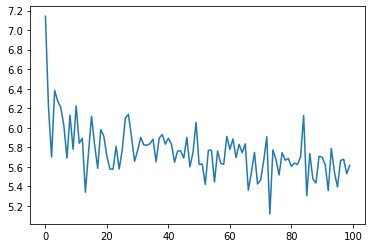

In [ ]:
A_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words,
                        hidden_size,
                        embedding_size).to(device)
A_attn_decoder1 = AdditiveAttnDecoderRNN(hidden_size,
                                         embedding_size,
                                         DE_subsets[0]['output_lang'].n_words,
                                         dropout_p=0.0).to(device)

A_plot_losses_1 = trainIters(A_encoder1,
                             A_attn_decoder1,
                             DE_subsets[0]['train_pairs'],
                             DE_subsets[0]['input_lang'],
                             DE_subsets[0]['output_lang'],
                             10000,
                             DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[0]['input_lang'],
  'output_lang': DE_subsets[0]['output_lang'],
  'encoder': A_encoder1.state_dict(),
  'attn_decoder': A_attn_decoder1.state_dict()
}, 'model/A_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/A_10000_S1.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[0]['input_lang'] = checkpoint['input_lang']
DE_subsets[0]['output_lang'] = checkpoint['output_lang']
A_encoder1 = EncoderRNN(DE_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
A_attn_decoder1 = AdditiveAttnDecoderRNN(hidden_size, embedding_size, DE_subsets[0]['output_lang'].n_words, dropout_p=0.0).to(device)
A_encoder1.load_state_dict(checkpoint['encoder'])
A_attn_decoder1.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
evaluateRandomly(A_encoder1, A_attn_decoder1, DE_subsets[0]['input_lang'], DE_subsets[0]['output_lang'], DE_subsets[0]['test_pairs'], DE_MAX_LENGTH, n = 1)

In [ ]:
A_BLEU_1 = evaluateBleu(A_encoder1,
                        A_attn_decoder1,
                        DE_subsets[0]['input_lang'],
                        DE_subsets[0]['output_lang'],
                        DE_subsets[0]['test_pairs'],
                        DE_MAX_LENGTH)
A_BLEU_1

0m 33s (- 22m 2s) (1000 2%)
1m 7s (- 21m 35s) (2000 4%)
1m 41s (- 20m 55s) (3000 7%)
2m 15s (- 20m 25s) (4000 9%)
2m 49s (- 19m 56s) (5000 12%)
3m 24s (- 19m 29s) (6000 14%)
4m 0s (- 19m 1s) (7000 17%)
4m 33s (- 18m 21s) (8000 19%)
5m 4s (- 17m 37s) (9000 22%)
5m 38s (- 17m 4s) (10000 24%)
6m 11s (- 16m 28s) (11000 27%)
6m 44s (- 15m 52s) (12000 29%)
7m 19s (- 15m 21s) (13000 32%)
7m 53s (- 14m 48s) (14000 34%)
8m 29s (- 14m 17s) (15000 37%)
9m 3s (- 13m 43s) (16000 39%)
9m 38s (- 13m 10s) (17000 42%)
10m 12s (- 12m 37s) (18000 44%)
10m 46s (- 12m 2s) (19000 47%)
11m 19s (- 11m 28s) (20000 49%)
11m 53s (- 10m 54s) (21000 52%)
12m 28s (- 10m 20s) (22000 54%)
13m 0s (- 9m 45s) (23000 57%)
13m 32s (- 9m 10s) (24000 59%)
14m 6s (- 8m 36s) (25000 62%)
14m 39s (- 8m 2s) (26000 64%)
15m 13s (- 7m 28s) (27000 67%)
15m 48s (- 6m 55s) (28000 69%)
16m 21s (- 6m 21s) (29000 72%)
16m 47s (- 5m 44s) (30000 74%)
17m 21s (- 5m 10s) (31000 77%)
17m 55s (- 4m 37s) (32000 79%)
18m 28s (- 4m 3s) (33000 81

[0.13881142743035974,
 0.03873483697585759,
 0.009306489420980023,
 0.0021108970840210245]

## LSTM Variants

In [ ]:
class LSTMEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(LSTMEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.LSTM(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
class LectureAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, dropout_p=0.1):
        super(LectureAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.LSTM(self.embedding_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)

        output, hidden = self.gru(output, hidden)
        # Attention scores are the softmax of the simple dot product between encoder and decoder hidden states.
        attn_weights = torch.bmm(encoder_outputs.unsqueeze(0),
                                  output.view(1,-1,1)
                                 ).view(1,-1)
        attn_weights = F.softmax(attn_weights, dim=1)
        # Attention output is attention scores multiplied by encoder hidden states
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # Attention outputs are concatenated with decoder hidden states at the end
        output = torch.cat((attn_applied[0], output[0]), 1)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class MultiplicativeAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, dropout_p=0.1):
        super(MultiplicativeAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.LSTM(self.embedding_size, self.hidden_size)
        self.attn_W = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)

        output, hidden = self.gru(output, hidden)
        # Attention scores are the encoder hidden states multiplied by the dot product between the weight matrix and the decoder hidden states.
        attn_weights = self.attn_W(output)
        attn_weights = torch.bmm(encoder_outputs.unsqueeze(0),
                                  output.view(1,-1,1)
                                 ).view(1,-1)
        attn_weights = F.softmax(attn_weights, dim=1)
        # Attention output is attention scores multiplied by encoder hidden states
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # Attention outputs are concatenated with decoder hidden states at the end
        output = torch.cat((attn_applied[0], output[0]), 1)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AdditiveAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, dropout_p=0.1):
        super(AdditiveAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.LSTM(self.embedding_size, self.hidden_size)
        self.attn_Wh = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_We = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_v = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)

        output, hidden = self.gru(output, hidden)

        # Attention scores are computed by first transforming both the decoder and encoder hidden states with separate linear transformation matrices.
        # They are summed together and passed through a tanh() function before being multiplied by a weight vector v
        # Finally the scores are given by taking the softmax of the intermediate output.
        attn_weights = torch.tanh(self.attn_Wh(output) + self.attn_We(encoder_outputs))
        attn_weights = attn_weights.bmm(self.attn_v.unsqueeze(2))
        attn_weights = F.softmax(attn_weights.view(1,-1), dim=1)
        # Attention output is attention scores multiplied by encoder hidden states
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # Attention outputs are concatenated with decoder hidden states at the end
        output = torch.cat((attn_applied[0], output[0]), 1)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
DE_MAX_LENGTH = max([len(a.split(' ')) for a,b in DE_subsets[0]['train_pairs']]
                  + [len(a.split(' ')) for a,b in DE_subsets[0]['test_pairs']]) + 1
embedding_size = 256
hidden_size = 256

1m 48s (- 16m 19s) (1000 10%) 6.1851
3m 35s (- 14m 23s) (2000 20%) 5.8426
5m 19s (- 12m 25s) (3000 30%) 5.4819
7m 0s (- 10m 31s) (4000 40%) 5.5513
8m 48s (- 8m 48s) (5000 50%) 5.6583
10m 33s (- 7m 2s) (6000 60%) 5.5227
12m 17s (- 5m 16s) (7000 70%) 5.4384
14m 2s (- 3m 30s) (8000 80%) 5.5098
15m 43s (- 1m 44s) (9000 90%) 5.4808
17m 27s (- 0m 0s) (10000 100%) 5.4640


<Figure size 432x288 with 0 Axes>

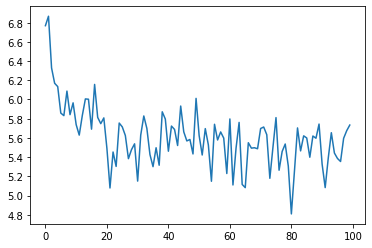

In [ ]:
L_encoder2 = LSTMEncoderRNN(DE_subsets[0]['input_lang'].n_words,
                               hidden_size,
                               embedding_size).to(device)
L_attn_decoder2 = LectureAttnDecoderRNN(hidden_size,
                                        embedding_size,
                                        DE_subsets[0]['output_lang'].n_words,
                                        dropout_p=0.0).to(device)

L_plot_losses_2 = trainIters(L_encoder2,
                             L_attn_decoder2,
                             DE_subsets[0]['train_pairs'],
                             DE_subsets[0]['input_lang'],
                             DE_subsets[0]['output_lang'],
                             10000,
                             DE_MAX_LENGTH)

In [ ]:
torch.save({
  'MAX_LENGTH': DE_MAX_LENGTH,
  'hidden_size': hidden_size,
  'embedding_size': embedding_size,
  'input_lang': DE_subsets[0]['input_lang'],
  'output_lang': DE_subsets[0]['output_lang'],
  'encoder': L_encoder2.state_dict(),
  'attn_decoder': L_attn_decoder2.state_dict()
}, 'model/L2_10000_S1.pth')

In [ ]:
checkpoint = torch.load('model/L2_10000_S1.pth')
DE_MAX_LENGTH = checkpoint['MAX_LENGTH']
embedding_size = checkpoint['embedding_size']
hidden_size = checkpoint['hidden_size']
DE_subsets[0]['input_lang'] = checkpoint['input_lang']
DE_subsets[0]['output_lang'] = checkpoint['output_lang']
L_encoder2 = LSTMEncoderRNN(DE_subsets[0]['input_lang'].n_words, hidden_size, embedding_size).to(device)
L_attn_decoder2 = LectureAttnDecoderRNN(hidden_size, embedding_size, DE_subsets[0]['output_lang'].n_words, dropout_p=0.0).to(device)
L_encoder2.load_state_dict(checkpoint['encoder'])
L_attn_decoder2.load_state_dict(checkpoint['attn_decoder'])

<All keys matched successfully>

In [ ]:
L_BLEU_2 = evaluateBleu(L_encoder2,
                        L_attn_decoder2,
                        DE_subsets[0]['input_lang'],
                        DE_subsets[0]['output_lang'],
                        DE_subsets[0]['test_pairs'],
                        DE_MAX_LENGTH)
L_BLEU_2

0m 34s (- 22m 19s) (1000 2%)
1m 10s (- 22m 32s) (2000 4%)
1m 44s (- 21m 31s) (3000 7%)
2m 20s (- 21m 9s) (4000 9%)
3m 0s (- 21m 15s) (5000 12%)
3m 37s (- 20m 42s) (6000 14%)
4m 17s (- 20m 22s) (7000 17%)
4m 52s (- 19m 39s) (8000 19%)
5m 25s (- 18m 51s) (9000 22%)
6m 1s (- 18m 14s) (10000 24%)
6m 37s (- 17m 37s) (11000 27%)
7m 13s (- 17m 1s) (12000 29%)
7m 50s (- 16m 25s) (13000 32%)
8m 22s (- 15m 42s) (14000 34%)
8m 57s (- 15m 5s) (15000 37%)
9m 28s (- 14m 22s) (16000 39%)
10m 4s (- 13m 46s) (17000 42%)
10m 38s (- 13m 9s) (18000 44%)
11m 14s (- 12m 34s) (19000 47%)
11m 49s (- 11m 58s) (20000 49%)
12m 27s (- 11m 25s) (21000 52%)
13m 2s (- 10m 49s) (22000 54%)
13m 35s (- 10m 11s) (23000 57%)
14m 10s (- 9m 35s) (24000 59%)
14m 50s (- 9m 3s) (25000 62%)
15m 25s (- 8m 27s) (26000 64%)
16m 1s (- 7m 52s) (27000 67%)
16m 36s (- 7m 16s) (28000 69%)
17m 16s (- 6m 42s) (29000 72%)
17m 45s (- 6m 4s) (30000 74%)
18m 26s (- 5m 30s) (31000 77%)
19m 2s (- 4m 54s) (32000 79%)
19m 39s (- 4m 19s) (33000 

[0.10560411996996312,
 0.017854426699575498,
 0.0011149779042773566,
 6.971146810056877e-80]